In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-sqad3jcq
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-sqad3jcq
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 326b0a57a80c6d0b4bad25ca7adf8138419ef1cb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10741 sha256=1c43b610d84440f376c57bb0b3d20f87e2433fdb6f06eb98d5fd7c81c461a971
  Stored in directory: /tmp/pip-ephem-wheel-cache-vaoiz_pt/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter


In [ ]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.5 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661204 sha256=0dab5eb51b417f9638689736e270bc03d3a6bca2ecc5e74fd1cf190eaf7af9f8
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully built pycuda


##Tutorials
https://www.youtube.com/watch?v=tHL5STNJKag&ab_channel=RobMulla
https://www.youtube.com/watch?v=FkiykIpNVaQ&ab_channel=VenelinValkov
https://www.youtube.com/watch?app=desktop&v=r5D6bnCJ490&embeds_referring_euri=https%3A%2F%2Fwww.leaky.ai%2F&feature=emb_imp_woyt&ab_channel=LearnA.I.withLeakyAI
https://www.youtube.com/watch?v=K_SjPRlf1c8&ab_channel=futureXskills


### Import-uri si elemente necesare pre-programare

In [ ]:
# Manipulare date și fișiere
import os
import shutil
import glob as gb
import xml.etree.ElementTree as ET

# Biblioteca Pandas
import pandas as pd

# Biblioteca NumPy
import numpy as np

# Plotare și vizualizare
import matplotlib.pyplot as plt

# Scikit-learn pentru metrici și validare
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import KFold

# TensorFlow și Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Torch și PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, Subset, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder

# Biblioteca PIL pentru procesarea imaginilor
from PIL import Image

# Montare Google Drive (pentru Google Colab)
from google.colab import drive


### Dam mount la drive pentru a lucra cu datele

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Observatii generale:
Setul de date:
    Datele sunt impartite in 3 clase, cu numar inegal de poze per clasa: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
    Acestea au fost preluate intr-un format ideal, au fost create special pentru a antrena un model, astfel nu
    au fost necesare multe preprocesari, doar verificari legate de dimensiuni. Modelul clasifica persoanele care poartă măști, nu le poartă sau le poartă în mod necorespunzător.

Am testat/antrenat mai multe modele, pentru fiecare am calculat acuratetea,train/validation loss.

## 1. Definim functiile si clasa necesare pentru a pregati imaginile de procesare

Bulina 1

In [ ]:
# Functia asta e ca sa citeasca XML-urile si sa le parseze in functie daca poza e cu masca, fara masca, sau purtata incorect
def parse_annotations(xml_path):
    tree = ET.parse(xml_path)  # Parseaza fisierul XML de la calea specificata si returneaza un obiect de tipul 'ElementTree'
    root = tree.getroot()  # Obtine radacina documentului XML

    data = []  # Initializeaza o lista goala pentru a stoca datele extrase
    for obj in root.findall('object'):  # Itereaza prin toate elementele 'object' din radacina XML
        label = obj.find('name').text  # Extragere textului din primul subelement 'name' al fiecarui 'object'
        filename = root.find('filename').text  # Extragere textului din elementul 'filename' al radacinii
        data.append((filename, label))  # Adauga un tuplu format din filename si label in lista de date

    return data  # Returneaza lista de date


In [ ]:
# Functia asta e ca sa trimita numele parsate si fisierele catre noua locatie unde sunt organizate
def parse_annotations_folder(annotations_folder):
    data = []# Initializeaza o lista goala pentru a stoca datele extrase din fisierele de anotari
    for filename in os.listdir(annotations_folder):# Parcurge fiecare fisier din folderul dat
        if filename.endswith('.xml'):# Verifica daca fisierul curent se termina cu extensia '.xml'
            filepath = os.path.join(annotations_folder, filename)# Construieste calea completa a fisierului
            data += parse_annotations(filepath)# Apelaza functia `parse_annotations` pe fisierul curent si adauga rezultatele la lista `data`
    return data # Returneaza lista cu toate datele extrase din fisierele de anotari


In [ ]:
# Se ia fisierul de la sursa, se determina destinatia si se creeaza folderele unde o sa fie fisierele organizate pe cele trei categorii
def organize_images(data, source_dir, target_dir):
    for filename, label in data:
        source_path = os.path.join(source_dir, filename)# Construieste calea completa a fisierului sursa folosind directorul sursa si numele fisierului
        target_path = os.path.join(target_dir, label, filename)# Construieste calea completa a fisierului destinatie folosind directorul destinatie, eticheta si numele fisierului
        os.makedirs(os.path.join(target_dir, label), exist_ok=True)# Creeaza directorul corespunzator etichetei in directorul destinatie, daca acesta nu exista
        shutil.copyfile(source_path, target_path)# Copiaza fisierul din locatia sursa in locatia destinatie


In [ ]:
# Aici vom rula propriu zis organizarea si vom prelua datele
annotations_path = '/content/drive/MyDrive/SIproiect/dataset/annotations/'
images_dir = '/content/drive/MyDrive/SIproiect/dataset/images/'
target_dir = '/content/drive/MyDrive/SIproiect/dataset/images_organized/'

# Se ruleaza o singura data ca sa imparta pozele in foldere (nu are sens sa mai rulez daca s au salvat deja)

# Transmitem adnotarile
#data = parse_annotations_folder(annotations_path)

# Le organizam in foldere
#organize_images(data, images_dir, target_dir)

In [ ]:
# Incarca si proceseaza imaginile, respectiv le aduce la dimensiunea dorita (200 x 200), e o clasa care ne ajuta la a crea seturile de date cu care vom lucra
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(200, 200)):
        self.root_dir = root_dir  # Seteaza directorul radacina unde sunt stocate datele
        self.transform = transform  # Transformari optinale pentru preprocesarea imaginilor
        self.target_size = target_size  # Dimensiunea la care vor fi redimensionate imaginile
        self.classes = os.listdir(root_dir)  # Lista tuturor claselor din directorul radacina
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}  # Dictionar pentru maparea clasei la un index
        self.data = self.load_data()  # Incarca datele folosind functia definita mai jos

    def load_data(self):
        data = []
        for cls in self.classes:  # Parcurge fiecare clasa
            class_dir = os.path.join(self.root_dir, cls)  # Construieste calea catre directorul clasei
            for file in os.listdir(class_dir):  # Parcurge fiecare fisier din directorul clasei
                data.append((os.path.join(class_dir, file), self.class_to_idx[cls]))  # Adauga un tuplu (cale fisier, index clasa) la lista de date
        return data  # Returneaza lista completa de date

    def __len__(self):
        return len(self.data)  # Returneaza numarul de elemente din setul de date

    def __getitem__(self, idx):
        img_path, label = self.data[idx]  # Obtine calea catre imagine si eticheta corespunzatoare indexului dat
        img = Image.open(img_path).convert('RGB')  # Deschide imaginea de la calea data si o converteste in RGB

        img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta

        if self.transform:  # Aplica transformarile daca acestea sunt definite
            img = self.transform(img)

        return img, label  # Returneaza perechea (imagine, eticheta)


## 2. Preprocesare

Bulina 2:

In [ ]:
# Definim valorile pentry mean si std, sunt valori similare cu cele de la ImageNet reprezentand:
# mean: valorile medii pentru intensitatea pixelilor pentru fiecare canal de culoare RGB
# std: deviatia intensitatii
mean = [0.485, 0.456, 0.406]
std = np.array([0.229, 0.224, 0.225])

In [ ]:
target_size = (200, 200)  # Dimensiunile dorite

# Preprocesare simpla
transform = transforms.Compose([
    transforms.CenterCrop(target_size),  # Taiem imaginea si pastram din mijloc dimensiunea dorita
    transforms.ToTensor(),  # Convertim la un PyTorch tensor
    transforms.Normalize(mean=mean, std=std),  # Normalizam imaginea
    transforms.Resize(target_size) # Dam resize
])

# Transformari augumentate
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Aleatoriu, orientam imaginea orizontal
    transforms.RandomRotation(degrees=10),  # Rotim imaginea aleatoriu in sus cu 10 grade
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Aleatoriu schimbam luminozitatea, contrast, saturatia, si hue( Seaborn dupa ce trebuie sa se imparta culoarea)
    transforms.RandomResizedCrop(target_size, scale=(0.8, 1.0), ratio=(0.75, 1.333)),  # Aleatoriu taiem si dam resize
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),  # Aplicam Gaussian blur cu o probabilite de 10 %
    transforms.ToTensor(),  # Convertim imaginea intr un PyTorch tensor
    transforms.Normalize(mean=mean, std=std),  # Normalizam imaginea
    transforms.Resize(target_size) # Dam resize
])

In [ ]:
# Cream dataset
dataset = CustomDataset(target_dir, transform=transform) # Creeaza un obiect dataset personalizat folosind directorul specificat si transformarile definite

# Cream data loader
batch_size = 32 # Seteaza marimea lotului de date procesat la o iteratie la 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # Creeaza un DataLoader care va incarca datele din dataset in loturi de cate 32 de exemple, amestecand ordinea datelor la fiecare epoca


In [ ]:
augmented_dataset = CustomDataset(target_dir, transform=augmented_transform) # aici sunt acele diferente mai majore

In [ ]:
# Aceasta functie are rolul de a afisa primele 5 imagini dintr-un set de date extras pentru a le vedea si a ne asigura ca totul a functionat corect
def display_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))# Creeaza un set pentru afisarea imaginilor

    for i in range(num_images):
        # Alege un index aleatoriu din setul de date
        index = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[index]

        image_np = image.permute(1, 2, 0).numpy()# Converteste tensorul imagine într-un array numpy

        # Inverseaza normalizarea pentru a reda culorile originale ale imaginii
        mean = torch.tensor([0.485, 0.456, 0.406])  # Mediile pentru fiecare canal de culoare
        std = torch.tensor([0.229, 0.224, 0.225])   # Deviatiile standard pentru fiecare canal de culoare
        image_np = std * image_np + mean  # Aplica formula pentru a inversa normalizarea
        image_np = np.clip(image_np, 0, 1)  # Asigura ca valorile raman intre 0 si 1

        # Afiseaza imaginea si eticheta asociata
        axes[i].imshow(image_np)  # Afiseaza imaginea
        axes[i].set_title(f'Label: {dataset.classes[label]}')  # Seteaza titlul axei cu eticheta clasei
        axes[i].axis('off')  # Ascunde axele graficului

    plt.tight_layout()  # Ajusteaza layout-ul pentru a preveni suprapunerea elementelor
    plt.show()  # Afiseaza figura cu toate subgraficele


<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


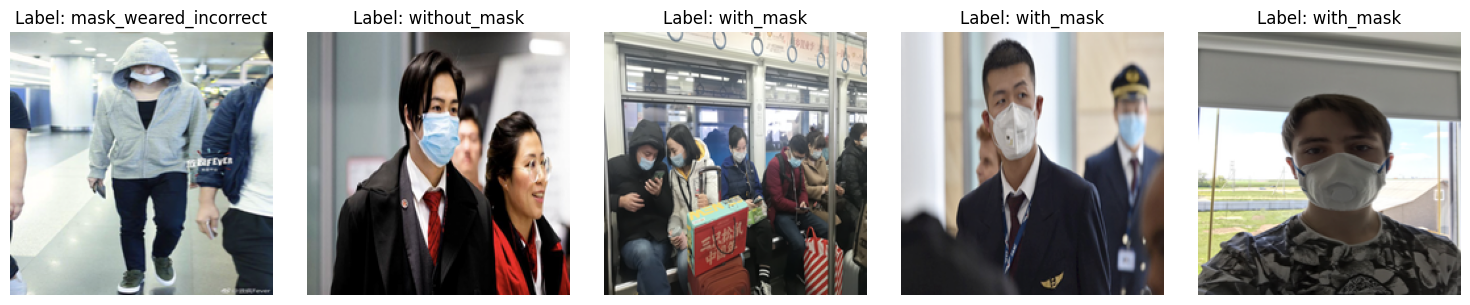

In [ ]:
# Afisam cateva imagini
display_images(dataset, num_images=5)

<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


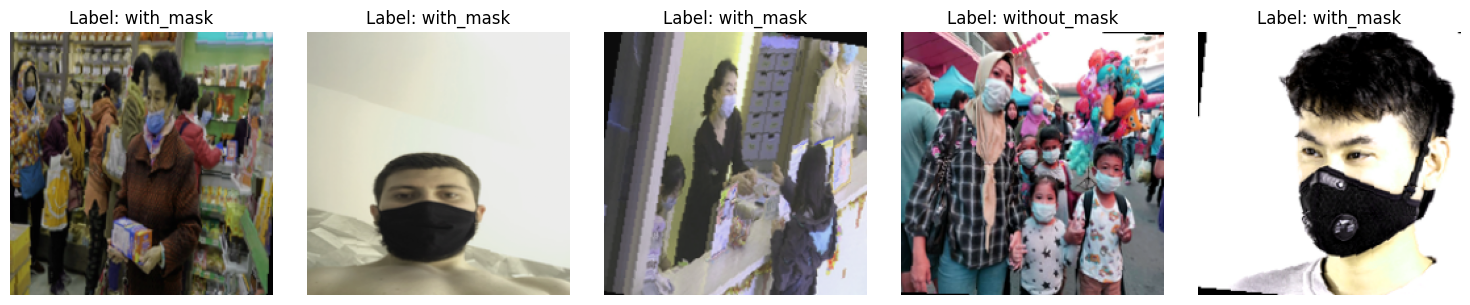

In [ ]:
# Afisam cateva imagini
display_images(augmented_dataset, num_images=5)

In [ ]:
# 'Compose' creeaza un lant de transformari; aici se combina mai multe transformari(altele) pentru prelucrarea datelor
preprocess_transform = transforms.Compose([
    transforms.ToTensor(),# 'ToTensor' converteste o imagine intr-un tensor PyTorch
    transforms.Normalize(mean=mean, std=std)# 'Normalize' normalizeaza un tensor imagine cu media si deviatia standard data pentru fiecare canal
])


In [ ]:
# Creaza un obiect 'preprocessed_dataset' folosind clasa 'CustomDataset'
preprocessed_dataset = CustomDataset(target_dir, transform=preprocess_transform)

In [ ]:
# Creaza un obiect 'preprocessed_augmented_dataset' folosind clasa 'CustomDataset'
preprocessed_augmented_dataset = CustomDataset(target_dir, transform=augmented_transform)

<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


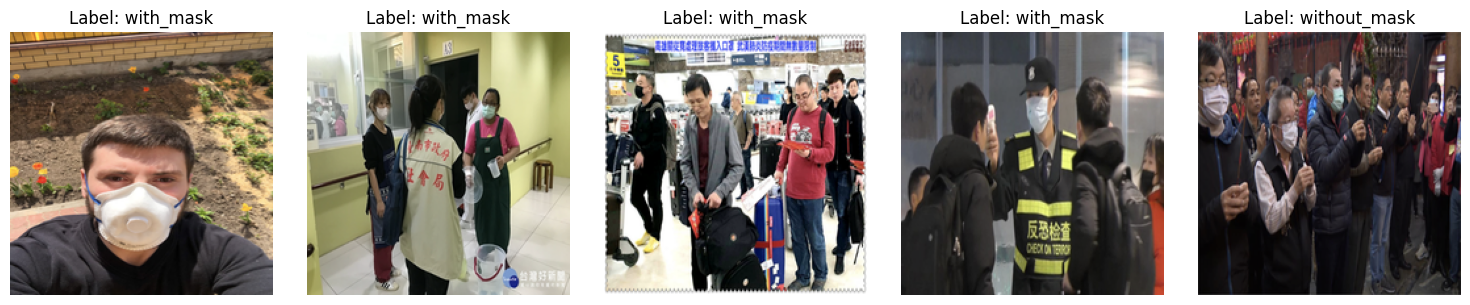

In [ ]:
display_images(preprocessed_dataset, num_images=5)

<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


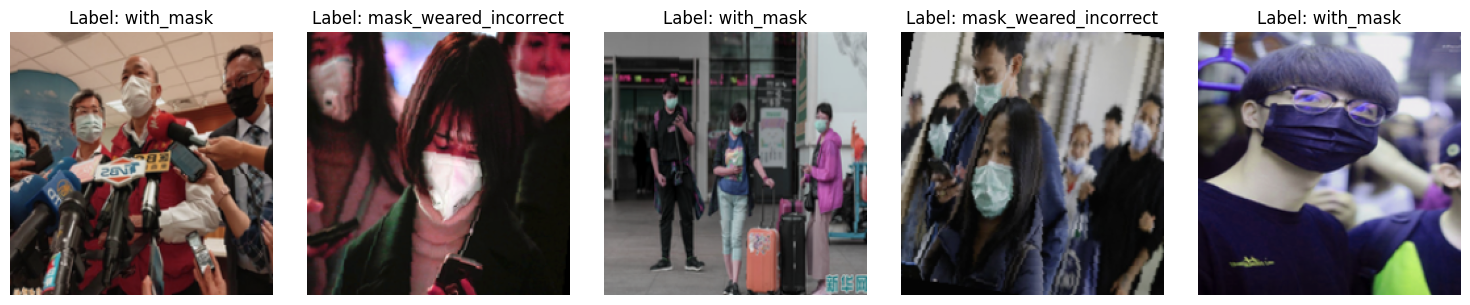

In [ ]:
display_images(preprocessed_augmented_dataset, num_images=5)

## 3. Histograma si distributia pe clase
Tot bulina 2

In [ ]:
# Defineste o functie pentru a afisa distributia claselor intr-un set de date
def plot_class_distribution(dataset, title):
    class_counts = {cls: 0 for cls in dataset.classes} # Creeaza un dictionar pentru a numara instantele fiecarei clase
    for _, label in dataset.data: # Parcurge datele setului pentru a numara etichetele
        class_counts[dataset.classes[label]] += 1 # Incrementeaza contorul pentru clasa corespunzatoare etichetei

    # Configurarea si afisarea graficului
    plt.figure(figsize=(8, 6)) # Seteaza dimensiunea figurii pentru grafic
    plt.bar(class_counts.keys(), class_counts.values()) # Creeaza un grafic de bare cu numarul de instante pe clase
    plt.title(title) # Seteaza titlul graficului
    plt.xlabel('Clase') # Seteaza eticheta axei X
    plt.ylabel('Cate?') # Seteaza eticheta axei Y
    plt.xticks(rotation=45) # Roteste etichetele de pe axa X cu 45 de grade
    plt.show() # Afiseaza graficul

# Defineste o functie pentru a afisa histogramele pixelilor pentru imagini
def plot_pixel_histograms(dataset, num_images=5):
    plt.figure(figsize=(15, 5)) # Seteaza dimensiunea figurii pentru histograme

    for i in range(num_images): # Repeta pentru numarul specificat de imagini
        index = torch.randint(len(dataset), size=(1,)).item() # Alege aleator un index din setul de date
        image, _ = dataset[index] # Preia imaginea corespunzatoare indexului
        image_np = image.permute(1, 2, 0).numpy() # Transforma imaginea din tensor in array numpy si reordoneaza dimensiunile

        for j in range(3): # Repeta pentru fiecare canal de culoare (RGB)
            plt.subplot(num_images, 3, i * 3 + j + 1) # Configureaza subplot pentru histograma curenta
            plt.hist(image_np[:, :, j].flatten(), bins=50, color=['red', 'green', 'blue'][j], alpha=0.5) # Afiseaza histograma valorilor pixelilor pentru canalul curent
            plt.title(f'Canal {j+1}') # Seteaza titlul subplotului
            plt.xlabel('Valoarea pixelului') # Seteaza eticheta axei X
            plt.ylabel('Frecventa') # Seteaza eticheta axei Y

    plt.tight_layout() # Ajusteaza automat parametrii subploturilor pentru a se incadra in figura
    plt.show() # Afiseaza histogramele


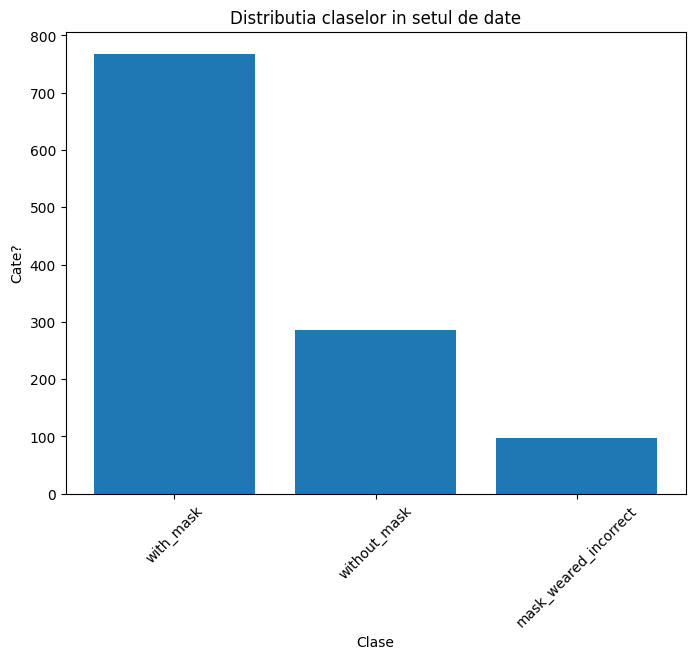

In [ ]:
plot_class_distribution(preprocessed_dataset, 'Distributia claselor in setul de date')

<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


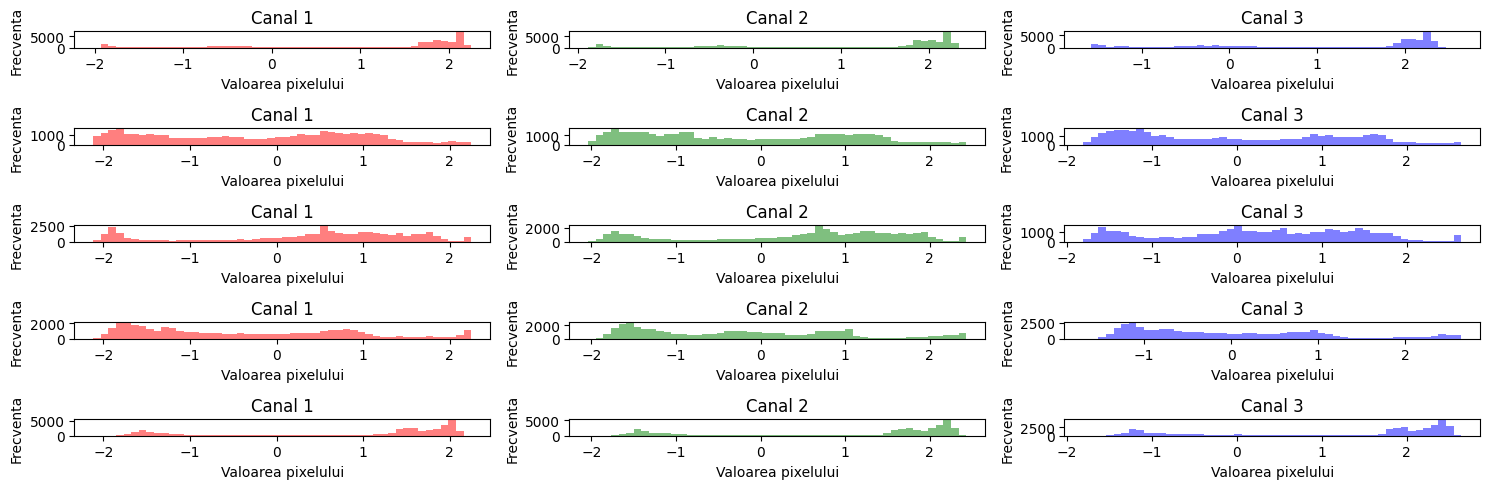

In [ ]:
# Aici avem canalele de pixeli si frecventele
plot_pixel_histograms(preprocessed_dataset)
# Frecventa -> cat de des apare un pixel
# Valoarea pixelului -> intensitate normalizata (nu a fost normalizata la -1 1 ci la -2 2)
# Canal -> ce culoare

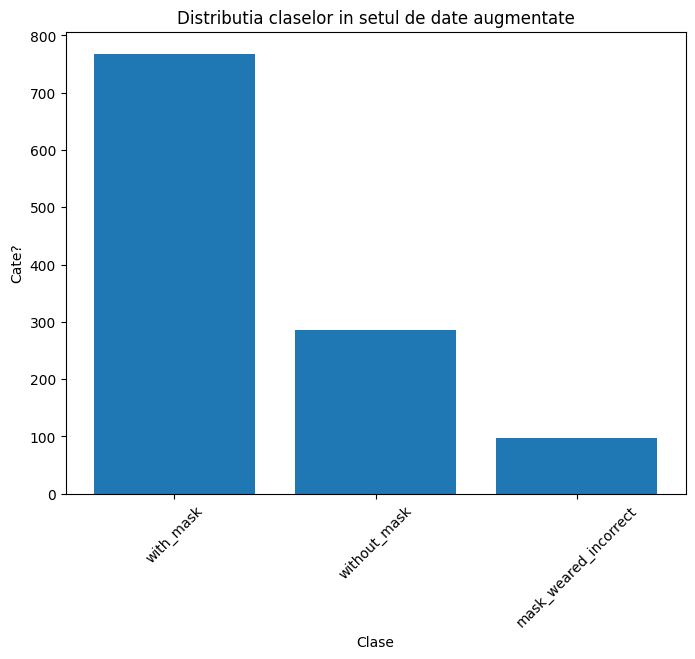

In [ ]:
plot_class_distribution(preprocessed_augmented_dataset, 'Distributia claselor in setul de date augmentate')

<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


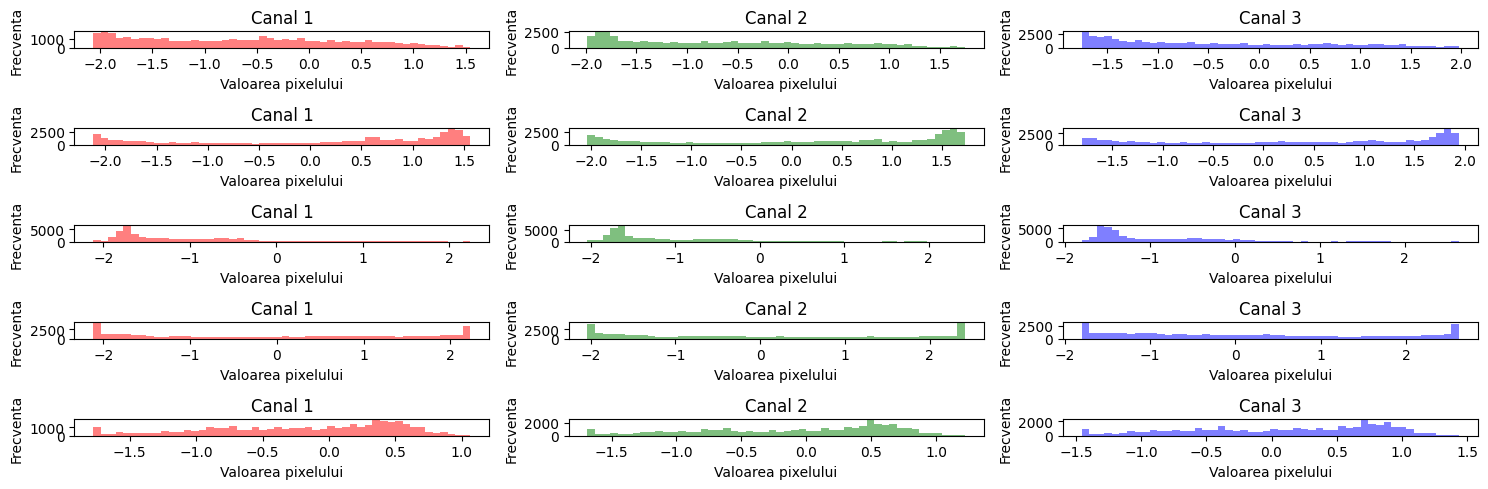

In [ ]:
plot_pixel_histograms(preprocessed_augmented_dataset)

## 3.1 Model preantrenat

Barem 3:

## Observatii generale:

Bază: Utilizează ResNet-18 de la PyTorch, adaptat pentru clasificare specifică prin înlocuirea ultimului strat.

Activare: Folosește implicit softmax prin pierderea entropiei încrucișate în antrenament.

Funcție de Pierdere : Entropie Încrucișată, optimă pentru clasificarea multi-clasă.

Optimizator: Adam, adecvat pentru gestionarea gradienților și adaptarea ratei de învățare.

Regim de Antrenament:
Epoci: 50, cu implementarea opririi timpurii după 3 epoci fără îmbunătățiri.
Performanță:

Monitorizare: Urmărește acuratețea de validare pentru a evalua generalizarea modelului.

Observații:
Eficiență: Antrenamentul reutilizează majoritatea arhitecturii ResNet-18, fiind mai eficient din punct de vedere computațional.

In [ ]:
ensemble_models = []

In [ ]:
class CNNWithResNet(nn.Module):
    def __init__(self, num_classes):
        super(CNNWithResNet, self).__init__()
        # Incarcam modelul pre-antrenat de ResNet
        resnet = models.resnet18(pretrained=True)
        # Stergem ultimul strat complet conectat de la final
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        # Adaug stratul meu propriu la NN (Practic am folosit un backbone si am adaugat un strat)
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
model = CNNWithResNet(num_classes=len(dataset.classes))

# Loss function si optimizare
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.1% learning rate (cat de repede invata)

train_size = int(0.8 * len(dataset)) # 0.8 = 80% din setul de date
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32 # e undeva si mai sus insa il rescriu ca sa se vada volumul

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

num_epochs = 50

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 50.0MB/s]


In [ ]:
train_losses = [] # Aceste arrays o sa ne ajutes sa facem plot-urile mai incolo
val_losses = []

best_val_accuracy = 0.0 # Cea mai mare acuratete gasita
patience = 3  # Numarul de epoci unde vom considera ca modelul nu a facut progrese
no_improvement_count = 0

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    try:
      for images, labels in train_loader:
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * images.size(0)  # Multiplicam marimea cu batch_size ul ca sa avem loss-ul corect
    except:
      print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
    train_loss /= len(train_loader.dataset)  # Impartim la numarul total de date

    # Validam modelul
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)  # Multiplicam la fel ca mai sus
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)  # Impartim la fel ca mai sus

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')  # Adjusted accuracy printing

    # Verificam daca exista imbunatatiri
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # Verificam daca ne oprim mai devreme iar daca da, afisam mesaj
    if no_improvement_count >= patience:
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')
        break

<ipython-input-8-b85e18f44b6a>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)


Epoch [1/50], Train Loss: 1.0278, Validation Loss: 3.6136, Validation Accuracy: 0.36
Epoch [2/50], Train Loss: 0.7243, Validation Loss: 0.7175, Validation Accuracy: 0.68
Epoch [3/50], Train Loss: 0.6789, Validation Loss: 0.7612, Validation Accuracy: 0.67
Epoch [4/50], Train Loss: 0.6379, Validation Loss: 0.8256, Validation Accuracy: 0.68
Epoch [5/50], Train Loss: 0.5959, Validation Loss: 0.9545, Validation Accuracy: 0.67
No improvement in validation accuracy for 3 epochs. Stopping training.


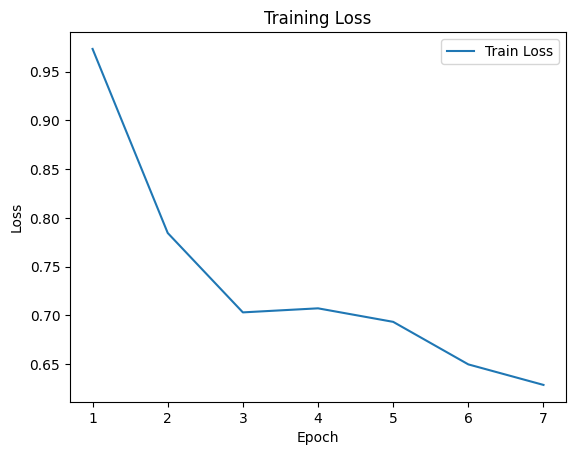

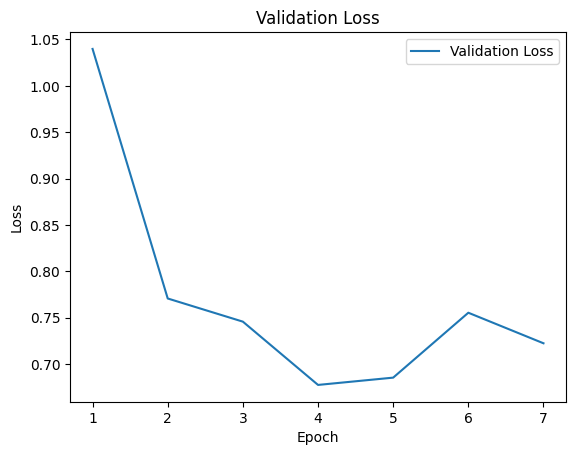

In [ ]:
ensemble_models.append(model) # Adaugam pentru comparatiile facute la confusion matrix

# print(len(train_losses), len(val_losses)) # aici era ca aveam eroare cu dimensiunile

plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

## 3.1.1 Experimente cu batch size-ul

Barem 4:

#### 3.1.1.1 Micsoram batch size-ul (barem 4)

In [ ]:
model = CNNWithResNet(num_classes=len(dataset.classes))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.1% learning rate

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 16 # Aici e modificarea, in rest e la fel
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

num_epochs = 10

train_losses = []
val_losses = []

best_val_accuracy = 0.0
patience = 3
no_improvement_count = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    try:
      for images, labels in train_loader:
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * images.size(0)
    except:
      print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
    train_loss /= len(train_loader.dataset)


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')  # Adjusted accuracy printing

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')
        break

<ipython-input-55-b85e18f44b6a>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)


Epoch [1/10], Train Loss: 0.9273, Validation Loss: 1.1049, Validation Accuracy: 0.70
Epoch [2/10], Train Loss: 0.7760, Validation Loss: 3.3765, Validation Accuracy: 0.65
Epoch [3/10], Train Loss: 0.7907, Validation Loss: 0.7549, Validation Accuracy: 0.70
Epoch [4/10], Train Loss: 0.7252, Validation Loss: 1.1147, Validation Accuracy: 0.71
Epoch [5/10], Train Loss: 0.7113, Validation Loss: 0.9489, Validation Accuracy: 0.59
Epoch [6/10], Train Loss: 0.6952, Validation Loss: 0.8088, Validation Accuracy: 0.71
Epoch [7/10], Train Loss: 0.6673, Validation Loss: 0.8605, Validation Accuracy: 0.68
No improvement in validation accuracy for 3 epochs. Stopping training.


#### 3.1.1.2 Marim batch size-ul (barem 4)

In [ ]:
ensemble_models.append(model) # adaugam modelul rulat

model = CNNWithResNet(num_classes=len(dataset.classes))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.1% learning rate

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64 # aici e modificarea si in rest la fel
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

num_epochs = 10

train_losses = []
val_losses = []

best_val_accuracy = 0.0
patience = 3
no_improvement_count = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    try:
      for images, labels in train_loader:
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * images.size(0)
    except:
      print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')  # Adjusted accuracy printing

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')
        break

<ipython-input-55-b85e18f44b6a>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)


Epoch [1/10], Train Loss: 0.9604, Validation Loss: 5.4963, Validation Accuracy: 0.48
Epoch [2/10], Train Loss: 0.7135, Validation Loss: 1.9161, Validation Accuracy: 0.59
Epoch [3/10], Train Loss: 0.6853, Validation Loss: 0.8989, Validation Accuracy: 0.70
Epoch [4/10], Train Loss: 0.6412, Validation Loss: 0.7488, Validation Accuracy: 0.71
Epoch [5/10], Train Loss: 0.6230, Validation Loss: 0.9729, Validation Accuracy: 0.70
Epoch [6/10], Train Loss: 0.6034, Validation Loss: 0.8899, Validation Accuracy: 0.66
Epoch [7/10], Train Loss: 0.5666, Validation Loss: 0.9262, Validation Accuracy: 0.59
No improvement in validation accuracy for 3 epochs. Stopping training.


### 3.1.2 Experimentam cu learning rate-ul

Barem 5:

In [ ]:
ensemble_models.append(model)

model = CNNWithResNet(num_classes=len(dataset.classes))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1) # 10% learning rate modificarea, aici e modificarea

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32 # revenim la 32 ca sa vedem diferentele, iar in rest la fel
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

num_epochs = 10

train_losses = []
val_losses = []

best_val_accuracy = 0.0
patience = 3
no_improvement_count = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    try:
      for images, labels in train_loader:
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * images.size(0)
    except:
      print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        try:
          for images, labels in val_loader:
              outputs = model(images)
              loss = criterion(outputs, labels)
              val_loss += loss.item() * images.size(0)
              _, predicted = torch.max(outputs, 1)
              total_samples += labels.size(0)
              total_correct += (predicted == labels).sum().item()
        except:
          print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
        val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')  # Adjusted accuracy printing

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')
        break

<ipython-input-55-b85e18f44b6a>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)


Epoch [1/10], Train Loss: 4.7690, Validation Loss: 1557.4117, Validation Accuracy: 0.64
Epoch [2/10], Train Loss: 1.5138, Validation Loss: 1.2198, Validation Accuracy: 0.66
Epoch [3/10], Train Loss: 0.8620, Validation Loss: 0.8559, Validation Accuracy: 0.66
Epoch [4/10], Train Loss: 0.8316, Validation Loss: 0.8632, Validation Accuracy: 0.66
Epoch [5/10], Train Loss: 0.8357, Validation Loss: 0.8446, Validation Accuracy: 0.66
No improvement in validation accuracy for 3 epochs. Stopping training.


### 3.1.3 Experimente cu optimizatorii

Barem 6:

In [ ]:
ensemble_models.append(model)

model = CNNWithResNet(num_classes=len(dataset.classes))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001) # folosim SGD si revenim la 0.1% learning rate

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

num_epochs = 10

train_losses = []
val_losses = []

best_val_accuracy = 0.0 #
patience = 3
no_improvement_count = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    try:
      for images, labels in train_loader:
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * images.size(0)
    except:
      print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        try:
          for images, labels in val_loader:
              outputs = model(images)
              loss = criterion(outputs, labels)
              val_loss += loss.item() * images.size(0)
              _, predicted = torch.max(outputs, 1)
              total_samples += labels.size(0)
              total_correct += (predicted == labels).sum().item()
        except:
          print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
        val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')  # Adjusted accuracy printing

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')
        break

<ipython-input-55-b85e18f44b6a>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)


Epoch [1/10], Train Loss: 0.8984, Validation Loss: 0.7512, Validation Accuracy: 0.70
Epoch [2/10], Train Loss: 0.8123, Validation Loss: 0.7397, Validation Accuracy: 0.69
Epoch [3/10], Train Loss: 0.7929, Validation Loss: 0.7330, Validation Accuracy: 0.70
Epoch [4/10], Train Loss: 0.7722, Validation Loss: 0.7304, Validation Accuracy: 0.71
Epoch [5/10], Train Loss: 0.7580, Validation Loss: 0.7232, Validation Accuracy: 0.71
Epoch [6/10], Train Loss: 0.7375, Validation Loss: 0.7180, Validation Accuracy: 0.71
Epoch [7/10], Train Loss: 0.7222, Validation Loss: 0.7188, Validation Accuracy: 0.71
Epoch [8/10], Train Loss: 0.7110, Validation Loss: 0.7154, Validation Accuracy: 0.71
Epoch [9/10], Train Loss: 0.6953, Validation Loss: 0.7134, Validation Accuracy: 0.73
Epoch [10/10], Train Loss: 0.6860, Validation Loss: 0.7160, Validation Accuracy: 0.72


### 3.1.4 Function losses

Barem 7:

In [ ]:
# Folosim alte doua metode pentru loss, KL Divergence si MSE (Mean Square Error -> eroare patrata medie) in loc de CrossEntropy
ensemble_models.append(model)

best_val_accuracy = 0.0 #
patience = 3
no_improvement_count = 0

criterion = nn.CrossEntropyLoss()

kl_criterion = nn.KLDivLoss()

mse_criterion = nn.MSELoss()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    try:
      for images, labels in train_loader:
          optimizer.zero_grad()
          outputs = model(images)
          ce_loss = criterion(outputs, labels)

          # Calculam KL Divergence loss
          kl_loss = kl_criterion(F.log_softmax(outputs, dim=1), F.softmax(labels, dim=1))

          # Calculam additional loss (e.g., MSE Loss)
          mse_loss = mse_criterion(outputs, labels)

          # Un loss combinat unde mse are 0.1 pondere
          combined_loss = ce_loss + kl_loss + 0.1 * mse_loss

          combined_loss.backward()
          optimizer.step()

          train_loss += combined_loss.item() * images.size(0)
    except:
      print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        try:
          for images, labels in val_loader:
              outputs = model(images)
              loss = criterion(outputs, labels)
              val_loss += loss.item() * images.size(0)
              _, predicted = torch.max(outputs, 1)
              total_samples += labels.size(0)
              total_correct += (predicted == labels).sum().item()
        except:
          print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
        val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')

    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')
        break


<ipython-input-55-b85e18f44b6a>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)


Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.
Epoch [1/10], Train Loss: 0.0000, Validation Loss: 0.7169, Validation Accuracy: 0.71
Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.
Epoch [2/10], Train Loss: 0.0000, Validation Loss: 0.7169, Validation Accuracy: 0.71
Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.
Epoch [3/10], Train Loss: 0.0000, Validation Loss: 0.7169, Validation Accuracy: 0.71
Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.
Epoch [4/10], Train Loss: 0.0000, Validation Loss: 0.7154, Validation Accuracy: 0.72
Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.
Epoch [5/10], Train Loss: 0.0000, Validation Loss: 0.7156, Valida

### 3.1.5 OPT, Accuracy Recall, Confusion Matrix

Barem 8:

In [ ]:
ensemble_models.append(model)

In [ ]:
best_val_accuracy = 0.0 #
patience = 3
no_improvement_count = 0

# Assuming train_dataset and val_dataset are already defined
train_idx = list(range(len(train_dataset)))
val_idx = list(range(len(val_dataset)))

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, sampler=val_sampler)

# Define entropy function
def entropy(predictions):
    probs = F.softmax(predictions, dim=1)
    log_probs = torch.log2(probs)
    entropy_per_instance = -torch.sum(probs * log_probs, dim=1)
    return torch.mean(entropy_per_instance).item()

# Ensemble predictions
ensemble_predictions = []
try:
    for images, labels in val_loader:
        with torch.no_grad():
            ensemble_output = torch.zeros(images.size(0), len(train_dataset.classes))
            for model in ensemble_models:
                model.eval()
                outputs = model(images)
                ensemble_output += outputs
            ensemble_output /= len(ensemble_models)
            ensemble_predictions.append(ensemble_output)
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please re-run the loaders and model or process fewer images.")
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(val_dataset, val_idx)

if ensemble_predictions:
    ensemble_predictions = torch.cat(ensemble_predictions, dim=0)
    ensemble_entropy = entropy(ensemble_predictions)

    # Calculate accuracy and recall
    ensemble_predicted_labels = torch.argmax(ensemble_predictions, dim=1)
    ensemble_accuracy = accuracy_score(val_dataset.targets, ensemble_predicted_labels)
    ensemble_recall = recall_score(val_dataset.targets, ensemble_predicted_labels, average='macro')

    # Generate confusion matrix
    conf_matrix = confusion_matrix(val_dataset.targets, ensemble_predicted_labels)

    writer = SummaryWriter()

    # Create heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(conf_matrix, cmap='viridis')

    # Add labels
    ax.set_xticks(np.arange(len(train_dataset.classes)))
    ax.set_yticks(np.arange(len(train_dataset.classes)))
    ax.set_xticklabels(train_dataset.classes, rotation=45)
    ax.set_yticklabels(train_dataset.classes)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')

    # Loop over data dimensions and create text annotations
    for i in range(len(train_dataset.classes)):
        for j in range(len(train_dataset.classes)):
            text = ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='w')

    # Add to TensorBoard
    writer.add_figure('Confusion Matrix', fig)
else:
    print("Ensemble predictions list is empty. Cannot compute entropy.")


<ipython-input-55-b85e18f44b6a>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)


An error occurred: 'Subset' object has no attribute 'classes'
Please re-run the loaders and model or process fewer images.
Ensemble predictions list is empty. Cannot compute entropy.


### 3.1.6 Cross validation

Barem 9:

In [ ]:
best_val_accuracy = 0.0 #
patience = 3
no_improvement_count = 0

# Impartim in K subseturi egale
k_folds = 3
kf = KFold(n_splits=k_folds)

# Iteram pentru fiecare subset
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold + 1}/{k_folds}')

    # Train si validare pentru subset
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    # Dataloadere pentru subseturi
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    # Initializam un model nou pentru fiecare subset
    model = CNNWithResNet(num_classes=len(dataset.classes))

    # Loss si optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # resetam variabilele
    best_val_accuracy = 0.0
    no_improvement_count = 0

    # training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        try:
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * images.size(0)
        except:
          print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            total_correct = 0
            total_samples = 0
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()
            val_loss /= len(val_loader.dataset)

        # Accuracy
        accuracy = total_correct / total_samples

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')

        # Imbunatatire
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Oprim daca nu progreseaza
        if no_improvement_count >= patience:
            print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')
            break

    print(f'Best Validation Accuracy for Fold {fold + 1}: {best_val_accuracy:.4f}')

Fold 1/3


<ipython-input-55-b85e18f44b6a>:25: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)


Epoch [1/10], Train Loss: 1.0304, Validation Loss: 2.6241, Validation Accuracy: 0.09
Epoch [2/10], Train Loss: 0.8522, Validation Loss: 0.9503, Validation Accuracy: 0.32
Epoch [3/10], Train Loss: 0.8034, Validation Loss: 0.7528, Validation Accuracy: 0.64
Epoch [4/10], Train Loss: 0.7760, Validation Loss: 0.3771, Validation Accuracy: 0.95
Epoch [5/10], Train Loss: 0.7235, Validation Loss: 0.8734, Validation Accuracy: 0.38
Epoch [6/10], Train Loss: 0.6915, Validation Loss: 1.0015, Validation Accuracy: 0.30
Epoch [7/10], Train Loss: 0.6419, Validation Loss: 0.9676, Validation Accuracy: 0.51
No improvement in validation accuracy for 3 epochs. Stopping training.
Best Validation Accuracy for Fold 1: 0.9479
Fold 2/3
Epoch [1/10], Train Loss: 1.1453, Validation Loss: 6.7462, Validation Accuracy: 0.27
Epoch [2/10], Train Loss: 0.8690, Validation Loss: 0.7518, Validation Accuracy: 0.80
Epoch [3/10], Train Loss: 0.8488, Validation Loss: 0.5737, Validation Accuracy: 0.86
Epoch [4/10], Train Loss: 

## 3.2 Model creat de mine

Bulina 3:

## Observatii generale

Modelul meu, SimpleCNN, utilizează o arhitectură cu trei straturi convoluționale, fiecare urmat de ReLU și MaxPooling, crescând numărul de canale de la 3 la 128. Aplatizarea output-ului convoluțional alimentează două straturi fully connected. Folosești CrossEntropyLoss și optimizerul Adam pentru a antrena modelul pe 50 de epoci, structurând antrenamentul și validarea pe seturi împărțite ale datelor. Observatii: modelul se antreneaza decent, este simplu structurat.

In [ ]:
ensemble_models = []

In [ ]:
# Acesta este modelul propriu cu 3 straturi convolutional si un pooling ; trecem de la 3 -> 32 -> 64 -> 128 de neuroni si apoi MaxPooling

# Defineste clasa pentru un model simplu de CNN definit de mine
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)# Primul strat convolutional, preia 3 canale de intrare, returneaza 32 canale de iesire
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)# Al doilea strat convolutional, preia 32 canale de intrare, returneaza 64 canale de iesire
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)# Al treilea strat convolutional, preia 64 canale de intrare, returneaza 128 canale de iesire
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Strat de pooling, reduce dimensiunea fiecarui canal la jumatate

        # Inlantuirea straturilor convolutionale si a straturilor de activare
        self.convs = nn.Sequential(self.conv1, nn.ReLU(), self.pool, self.conv2, nn.ReLU(), self.pool, self.conv3, nn.ReLU(), self.pool)

        # Calculeaza dimensiunea de iesire pentru a o conecta la straturile fully connected
        self._to_linear = None
        self._get_flatten_size((3, 200, 200))  # Marimea initiala a imaginii


        self.fc1 = nn.Linear(self._to_linear, 512)# Primul strat fully connected, preia _to_linear neuroni si returneaza 512
        self.fc2 = nn.Linear(512, num_classes)# Al doilea strat fully connected, preia 512 neuroni si returneaza numarul de clase

    # Functia care calculeaza dimensiunea output-ului dupa straturile convolutionale
    def _get_flatten_size(self, img_dim):
        x = torch.rand(1, *img_dim) # Creeaza un tensor aleatoriu cu dimensiunea specificata (in exemplul acesta, 3 canale de culoare, 200x200 pixeli)
        x = self.convs(x) # Aplica straturile convolutionale si de pooling la tensorul aleatoriu pentru a determina dimensiunea finala
        self._to_linear = x.numel() # Numara totalul elementelor din tensorul rezultat, pentru a determina cate caracteristici intră în primul strat fully connected


    # Functia de propagare inainte a datelor prin retea
    def forward(self, x):
        x = self.convs(x)  # Aplica straturile convolutionale si de pooling
        x = torch.flatten(x, 1)  # Aplatizeaza tensorul pentru a putea fi prelucrat de straturile fully connected
        x = F.relu(self.fc1(x))  # Aplica relu si primul strat fully connected
        x = self.fc2(x)  # Aplica al doilea strat fully connected
        return x

# Creaza o instanta a modelului cu 3 clase de iesire
model = SimpleCNN(num_classes=3)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convs): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=80000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=Tru

In [ ]:
# Pastram aceiasi parametri ca la celalalt model si repetam procesul cu modelul nou -- abandonam

criterion = nn.CrossEntropyLoss()# Creeaza un obiect de loss folosind Cross-Entropy Loss, util pentru clasificarea cu mai multe clase.

# Initializeaza optimizerul Adam pentru ajustarea parametrilor modelului, cu o rata de invatare de 0.001.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 0.1% learning rate

train_size = int(0.8 * len(dataset))# Calculeaza dimensiunea setului de antrenament ca fiind 80% din totalul dataset-ului.
val_size = len(dataset) - train_size# Calculeaza dimensiunea setului de validare ca fiind restul datelor din dataset dupa ce se scad cele de antrenament.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])# Imparte dataset-ul in sub-seturi de antrenament si validare folosind proportiile calculate.

batch_size = 32# Seteaza dimensiunea fiecarui batch la 32.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)# Creeaza un DataLoader pentru setul de antrenament, care amesteca datele si le incarca in batch-uri de dimensiunea specificata.
val_loader = DataLoader(val_dataset, batch_size=batch_size)# Creeaza un DataLoader pentru setul de validare, care incarca datele in batch-uri de dimensiunea specificata.

num_epochs = 50# Seteaza numarul de epoci de antrenament la 50.


In [ ]:
train_losses = []  # Creaza o lista pentru a stoca pierderile de antrenament
val_losses = []  # Creaza o lista pentru a stoca pierderile de validare

best_val_accuracy = 0.0  # Initializeaza cea mai buna acuratete de validare
patience = 10  # Seteaza numarul de epoci fara imbunatatiri dupa care antrenamentul se opreste
no_improvement_count = 0  # Contor pentru numarul de epoci fara imbunatatiri

for epoch in range(num_epochs):  # Ruleaza bucla pentru numarul specificat de epoci
    model.train()  # Seteaza modelul pe modul de antrenament
    train_loss = 0.0  # Initializeaza pierderea de antrenament pentru epoca curenta
    try:
      for images, labels in train_loader:  # Itereaza peste fiecare lot de imagini si etichete din setul de antrenament
          optimizer.zero_grad()  # Reseteaza gradientii optimizerului
          outputs = model(images)  # Calculeaza predictiile modelului pentru imaginile lotului curent
          loss = criterion(outputs, labels)  # Calculeaza pierderea folosind predictiile si etichetele reale
          loss.backward()  # Calculeaza gradientii pierderii
          optimizer.step()  # Actualizeaza parametrii modelului folosind gradientii calculati
          train_loss += loss.item() * images.size(0)  # Aduna pierderea scalata la numarul de imagini la pierderea totala de antrenament
    except:
      print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
    train_loss /= len(train_loader.dataset)  # Calculeaza media pierderii de antrenament pe toate datele

    model.eval()  # Seteaza modelul pe modul de evaluare
    val_loss = 0.0  # Initializeaza pierderea de validare pentru epoca curenta
    with torch.no_grad():  # Blocheaza calculul gradientilor pentru economie de memorie si timp de calcul
        total_correct = 0  # Contor pentru numarul total de predictii corecte
        total_samples = 0  # Contor pentru numarul total de exemple testate
        for images, labels in val_loader:  # Itereaza peste fiecare lot de imagini si etichete din setul de validare
            outputs = model(images)  # Calculeaza predictiile modelului pentru imaginile lotului curent
            loss = criterion(outputs, labels)  # Calculeaza pierderea folosind predictiile si etichetele reale
            val_loss += loss.item() * images.size(0)  # Aduna pierderea scalata la numarul de imagini la pierderea totala de validare
            _, predicted = torch.max(outputs, 1)  # Determina clasa prezisa pentru fiecare imagine din lot
            total_samples += labels.size(0)  # Adauga numarul de etichete din lot la totalul de exemple testate
            total_correct += (predicted == labels).sum().item()  # Adauga numarul de predictii corecte la contorul total
        val_loss /= len(val_loader.dataset)  # Calculeaza media pierderii de validare pe toate datele

    train_losses.append(train_loss)  # Adauga pierderea de antrenament calculata la lista de pierderi de antrenament
    val_losses.append(val_loss)  # Adauga pierderea de validare calculata la lista de pierderi de validare

    accuracy = total_correct / total_samples  # Calculeaza acuratetea de validare pentru epoca curenta
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')  # Afiseaza informatii despre epoca

    if accuracy > best_val_accuracy:  # Verifica daca acuratetea curenta este mai buna decat cea mai buna acuratete anterior obtinuta
        best_val_accuracy = accuracy  # Actualizeaza cea mai buna acuratete de validare
        no_improvement_count = 0  # Reseteaza contorul de epoci fara imbunatatiri
    else:
        no_improvement_count += 1  # Incrementeaza contorul de epoci fara imbunatatiri

    if no_improvement_count >= patience:  # Daca numarul de epoci fara imbunatatiri depaseste pragul de toleranta
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')  # Afiseaza un mesaj si opreste antrenamentul
        break  # Iese din bucla de antrenament


<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


Epoch [1/50], Train Loss: 1.5859, Validation Loss: 0.8811, Validation Accuracy: 0.64
Epoch [2/50], Train Loss: 0.8202, Validation Loss: 0.8898, Validation Accuracy: 0.64
Epoch [3/50], Train Loss: 0.8059, Validation Loss: 0.8966, Validation Accuracy: 0.63
Epoch [4/50], Train Loss: 0.7628, Validation Loss: 0.9245, Validation Accuracy: 0.61
Epoch [5/50], Train Loss: 0.6899, Validation Loss: 1.0364, Validation Accuracy: 0.55
Epoch [6/50], Train Loss: 0.6165, Validation Loss: 1.0728, Validation Accuracy: 0.49
Epoch [7/50], Train Loss: 0.5406, Validation Loss: 1.3496, Validation Accuracy: 0.45
Epoch [8/50], Train Loss: 0.5133, Validation Loss: 1.3813, Validation Accuracy: 0.45
Epoch [9/50], Train Loss: 0.4661, Validation Loss: 1.6351, Validation Accuracy: 0.47
Epoch [10/50], Train Loss: 0.4445, Validation Loss: 1.4614, Validation Accuracy: 0.47
Epoch [11/50], Train Loss: 0.4523, Validation Loss: 1.5184, Validation Accuracy: 0.47
No improvement in validation accuracy for 10 epochs. Stopping t

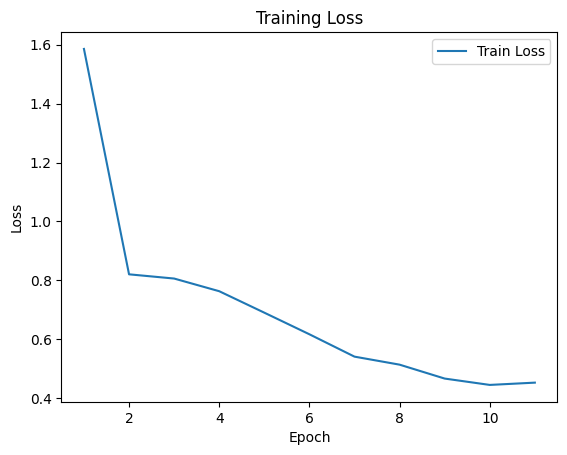

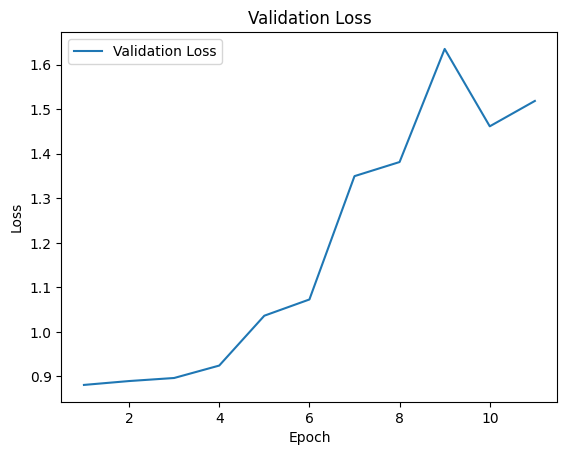

In [ ]:
# print(len(train_losses), len(val_losses))

ensemble_models.append(model)  # Adauga modelul curent la lista de modele de ansamblu

plt.figure()  # Initializeaza o noua figura pentru a desena graficul
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')  # Traseaza graficul pierderilor de antrenament
plt.xlabel('Epoch')  # Eticheteaza axa x cu 'Epoch'
plt.ylabel('Loss')  # Eticheteaza axa y cu 'Loss'
plt.title('Training Loss')  # Seteaza titlul graficului ca 'Training Loss'
plt.legend()  # Adauga legenda graficului
plt.show()  # Afiseaza graficul

plt.figure()  # Initializeaza o noua figura pentru al doilea grafic
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')  # Traseaza graficul pierderilor de validare
plt.xlabel('Epoch')  # Eticheteaza axa x cu 'Epoch'
plt.ylabel('Loss')  # Eticheteaza axa y cu 'Loss'
plt.title('Validation Loss')  # Seteaza titlul graficului ca 'Validation Loss'
plt.legend()  # Adauga legenda graficului
plt.show()  # Afiseaza graficul


## 3.2.1 Experimente cu batch size-ul

Bulina 4

Cu batch size mai mic, modelul preia mai in amanunt informatiile, ceea ce face ca trainingul sa fie mai lung.

### 3.2.1.1 Micsoram batch size-ul
Bulina 4

## Observatii generale
Ca la Observatii generale de la 3.2 doar ca la Observatii: modelul se antreneaza binisor, este simplu structurat si are performante scazute.

In [ ]:
ensemble_models.append(model) # Adaugam modelul rulat in lista de modele ensemble

model = SimpleCNN(num_classes=len(dataset.classes)) # Definim un nou model CNN cu numarul de clase din dataset

criterion = nn.CrossEntropyLoss() # Stabilim criteriul de pierdere ca fiind pierderea entropiei incrucisate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Definim optimizatorul ca fiind Adam cu rata de invatare de 0.001

train_size = int(0.8 * len(dataset)) # Calculam dimensiunea setului de antrenament ca 80% din dataset
val_size = len(dataset) - train_size # Restul datasetului este folosit pentru validare

train_dataset, val_dataset = random_split(dataset, [train_size, val_size]) # Impartim datasetul in set de antrenament si validare

batch_size = 16 # Stabilim dimensiunea lotului de date la 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Cream loader-ul pentru antrenament cu amestecare
val_loader = DataLoader(val_dataset, batch_size=batch_size) # Cream loader-ul pentru validare

num_epochs = 50 # Numarul total de epoci de antrenament

train_losses = [] # Lista pentru stocarea pierderilor de antrenament
val_losses = [] # Lista pentru stocarea pierderilor de validare

best_val_accuracy = 0.0 # Cel mai bun scor de acuratete pe validare
patience = 10 # Numarul de epoci fara imbunatatiri inainte de a opri antrenamentul
no_improvement_count = 0 # Contor pentru epoci fara imbunatatiri

for epoch in range(num_epochs): # Iteram prin fiecare epoca
    model.train() # Setam modelul in modul de antrenament
    train_loss = 0.0 # Initializam pierderea de antrenament pentru epoca
    try:
      for images, labels in train_loader: # Iteram prin fiecare lot de imagini si etichete din setul de antrenament
          optimizer.zero_grad() # Resetam gradientii
          outputs = model(images) # Obtinem outputurile modelului
          loss = criterion(outputs, labels) # Calculam pierderea
          loss.backward() # Aplicam backpropagation
          optimizer.step() # Actualizam parametrii modelului
          train_loss += loss.item() * images.size(0) # Acumulam pierderea scalata cu numarul de imagini
    except:
      print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si procesezi mai putine imagini.")
    train_loss /= len(train_loader.dataset)  # Impartim pierderea totala la numarul de exemple din setul de antrenament

    model.eval() # Setam modelul in modul de evaluare
    val_loss = 0.0 # Initializam pierderea de validare pentru epoca
    with torch.no_grad(): # Blocam calculul gradientilor
        total_correct = 0
        total_samples = 0
        for images, labels in val_loader: # Iteram prin fiecare lot de imagini si etichete din setul de validare
            outputs = model(images) # Obtinem outputurile modelului
            loss = criterion(outputs, labels) # Calculam pierderea
            val_loss += loss.item() * images.size(0) # Acumulam pierderea scalata cu numarul de imagini
            _, predicted = torch.max(outputs, 1) # Determinam clasa prezisa
            total_samples += labels.size(0) # Actualizam numarul total de exemple testate
            total_correct += (predicted == labels).sum().item() # Actualizam numarul total de predictii corecte
        val_loss /= len(val_loader.dataset) # Impartim pierderea totala la numarul de exemple din setul de validare

    train_losses.append(train_loss) # Adaugam pierderea de antrenament la lista
    val_losses.append(val_loss) # Adaugam pierderea de validare la lista

    accuracy = total_correct / total_samples # Calculam acuratetea
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')  # Afisam informatiile despre epoca

    if accuracy > best_val_accuracy: # Verificam daca acuratetea curenta este cea mai buna
        best_val_accuracy = accuracy # Actualizam cea mai buna acuratete
        no_improvement_count = 0 # Resetam contorul de epoci fara imbunatatiri
    else:
        no_improvement_count += 1 # Incrementam contorul de epoci fara imbunatatiri

    if no_improvement_count >= patience: # Verificam daca s-a atins numarul de epoci fara imbunatatiri
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.') # Afisam un mesaj si oprim antrenamentul
        break


<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


Epoch [1/50], Train Loss: 1.3252, Validation Loss: 0.9904, Validation Accuracy: 0.65
Epoch [2/50], Train Loss: 0.8234, Validation Loss: 0.8953, Validation Accuracy: 0.65
Epoch [3/50], Train Loss: 0.7979, Validation Loss: 1.0256, Validation Accuracy: 0.65
Epoch [4/50], Train Loss: 0.7713, Validation Loss: 0.9278, Validation Accuracy: 0.64
Epoch [5/50], Train Loss: 0.7506, Validation Loss: 0.9321, Validation Accuracy: 0.59
Epoch [6/50], Train Loss: 0.7080, Validation Loss: 0.9700, Validation Accuracy: 0.52
Epoch [7/50], Train Loss: 0.6615, Validation Loss: 1.0728, Validation Accuracy: 0.52
Epoch [8/50], Train Loss: 0.5760, Validation Loss: 1.1453, Validation Accuracy: 0.50
Epoch [9/50], Train Loss: 0.5433, Validation Loss: 1.3237, Validation Accuracy: 0.50
Epoch [10/50], Train Loss: 0.5083, Validation Loss: 1.2792, Validation Accuracy: 0.45
Epoch [11/50], Train Loss: 0.4929, Validation Loss: 1.5124, Validation Accuracy: 0.49
No improvement in validation accuracy for 10 epochs. Stopping t

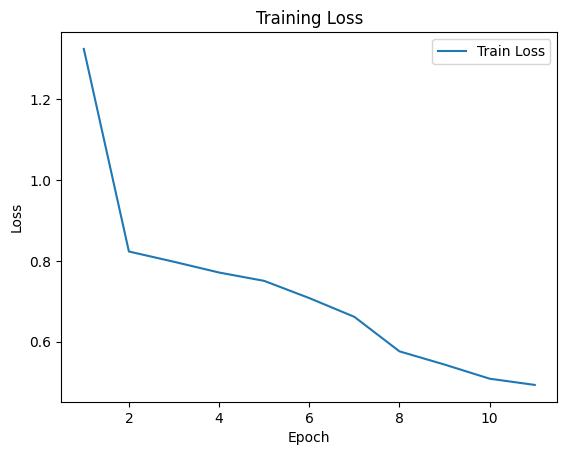

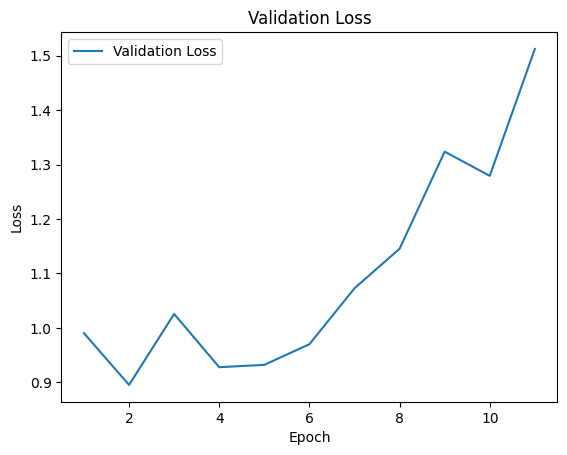

In [ ]:
plt.figure()  # Initializeaza o noua figura pentru a desena graficul
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')  # Traseaza graficul pierderilor de antrenament
plt.xlabel('Epoch')  # Eticheteaza axa x cu 'Epoch'
plt.ylabel('Loss')  # Eticheteaza axa y cu 'Loss'
plt.title('Training Loss')  # Seteaza titlul graficului ca 'Training Loss'
plt.legend()  # Adauga legenda graficului
plt.show()  # Afiseaza graficul

plt.figure()  # Initializeaza o noua figura pentru al doilea grafic
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')  # Traseaza graficul pierderilor de validare
plt.xlabel('Epoch')  # Eticheteaza axa x cu 'Epoch'
plt.ylabel('Loss')  # Eticheteaza axa y cu 'Loss'
plt.title('Validation Loss')  # Seteaza titlul graficului ca 'Validation Loss'
plt.legend()  # Adauga legenda graficului
plt.show()  # Afiseaza graficul

### 3.2.1.2 Marim batch size-ul
Tot bulina 4

## Observatii generale
Ca la Observatii generale de la 3.2 doar ca la Observatii: modelul se antreneaza binisor, este simplu structurat si are performante mai ridicate.

In [ ]:
ensemble_models.append(model)  # Adauga modelul curent in lista de modele ensemble

model = SimpleCNN(num_classes=len(dataset.classes))  # Creeaza un model CNN simplu cu numarul de clase din dataset

criterion = nn.CrossEntropyLoss()  # Defineste functia de pierdere ca fiind pierderea entropiei incrucisate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Seteaza optimizatorul ca fiind Adam cu o rata de invatare de 0.001

train_size = int(0.8 * len(dataset))  # Calculeaza dimensiunea setului de antrenament ca 80% din dataset
val_size = len(dataset) - train_size  # Calculeaza dimensiunea setului de validare

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  # Imparte datasetul in set de antrenament si set de validare

batch_size = 64  # Seteaza dimensiunea batch-ului pentru incarcare
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creeaza DataLoader pentru antrenament cu amestecare
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # Creeaza DataLoader pentru validare

num_epochs = 50  # Numarul total de epoci pentru antrenament

train_losses = []  # Initializeaza lista pentru pierderile de antrenament
val_losses = []  # Initializeaza lista pentru pierderile de validare

best_val_accuracy = 0.0  # Stabileste cea mai buna acuratete de validare initiala la 0.0
patience = 10  # Stabileste numarul de epoci fara imbunatatiri inainte de a opri antrenamentul
no_improvement_count = 0  # Contor pentru epocile fara imbunatatiri

for epoch in range(num_epochs):  # Ciclu pentru fiecare epoca de antrenament
    model.train()  # Seteaza modelul in modul de antrenament
    train_loss = 0.0  # Initializeaza pierderea de antrenament pentru epoca curenta
    try:
      for images, labels in train_loader:  # Itereaza peste fiecare batch din loader-ul de antrenament
          optimizer.zero_grad()  # Reseteaza gradientii in optimizator
          outputs = model(images)  # Calculeaza predictiile modelului pentru imaginile actuale
          loss = criterion(outputs, labels)  # Calculeaza pierderea intre predictii si etichetele reale
          loss.backward()  # Calculeaza gradientii
          optimizer.step()  # Actualizeaza parametrii modelului
          train_loss += loss.item() * images.size(0)  # Adauga pierderea ponderata pentru acest batch la pierderea totala
    except:
      print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
    train_loss /= len(train_loader.dataset)  # Calculeaza pierderea medie de antrenament

    model.eval()  # Seteaza modelul in modul de evaluare
    val_loss = 0.0  # Initializeaza pierderea de validare pentru epoca curenta
    with torch.no_grad():  # Bloc pentru a opri calculul gradientilor
        total_correct = 0  # Initializeaza numarul total de predictii corecte
        total_samples = 0  # Initializeaza numarul total de mostre evaluate
        for images, labels in val_loader:  # Itereaza peste fiecare batch din loader-ul de validare
            outputs = model(images)  # Calculeaza predictiile modelului pentru imaginile actuale
            loss = criterion(outputs, labels)  # Calculeaza pierderea intre predictiile si etichetele reale
            val_loss += loss.item() * images.size(0)  # Adauga pierderea ponderata pentru acest batch la pierderea totala de validare
            _, predicted = torch.max(outputs, 1)  # Determina clasa prezisa pentru fiecare imagine
            total_samples += labels.size(0)  # Adauga numarul de etichete in numarul total de mostre
            total_correct += (predicted == labels).sum().item()  # Adauga numarul de predictii corecte la total
        val_loss /= len(val_loader.dataset)  # Calculeaza pierderea medie de validare

    train_losses.append(train_loss)  # Adauga pierderea de antrenament la lista de pierderi
    val_losses.append(val_loss)  # Adauga pierderea de validare la lista de pierderi

    accuracy = total_correct / total_samples  # Calculeaza acuratetea de validare pentru epoca curenta
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')  # Afiseaza rezultatele pentru epoca curenta

    if accuracy > best_val_accuracy:  # Verifica daca acuratetea curenta este mai buna decat cea mai buna pana acum
        best_val_accuracy = accuracy  # Actualizeaza cea mai buna acuratete
        no_improvement_count = 0  # Reseteaza contorul pentru epoci fara imbunatatiri
    else:
        no_improvement_count += 1  # Incrementeaza contorul pentru epoci fara imbunatatiri

    if no_improvement_count >= patience:  # Verifica daca s-a atins numarul de epoci fara imbunatatiri
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')  # Afiseaza mesaj de oprire antrenament
        break  # Intrerupe ciclul de antrenament


<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


Epoch [1/50], Train Loss: 1.4087, Validation Loss: 0.8005, Validation Accuracy: 0.69
Epoch [2/50], Train Loss: 0.8596, Validation Loss: 0.7824, Validation Accuracy: 0.69
Epoch [3/50], Train Loss: 0.8154, Validation Loss: 0.7988, Validation Accuracy: 0.69
Epoch [4/50], Train Loss: 0.8008, Validation Loss: 0.8012, Validation Accuracy: 0.69
Epoch [5/50], Train Loss: 0.7840, Validation Loss: 0.8825, Validation Accuracy: 0.69
Epoch [6/50], Train Loss: 0.7484, Validation Loss: 0.8650, Validation Accuracy: 0.68
Epoch [7/50], Train Loss: 0.6913, Validation Loss: 0.9092, Validation Accuracy: 0.57
Epoch [8/50], Train Loss: 0.6132, Validation Loss: 1.0824, Validation Accuracy: 0.54
Epoch [9/50], Train Loss: 0.5585, Validation Loss: 1.2754, Validation Accuracy: 0.53
Epoch [10/50], Train Loss: 0.5359, Validation Loss: 1.1819, Validation Accuracy: 0.53
Epoch [11/50], Train Loss: 0.4838, Validation Loss: 1.3800, Validation Accuracy: 0.48
No improvement in validation accuracy for 10 epochs. Stopping t

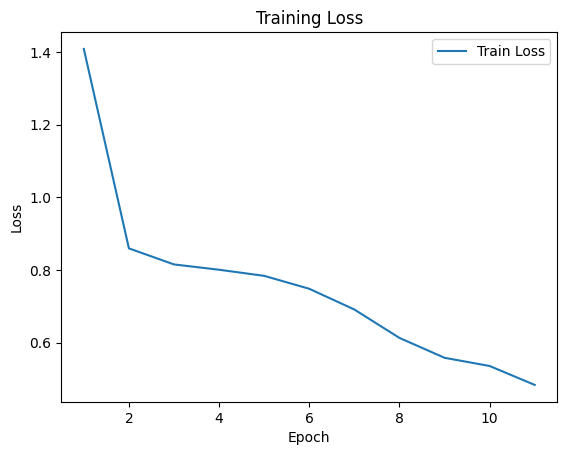

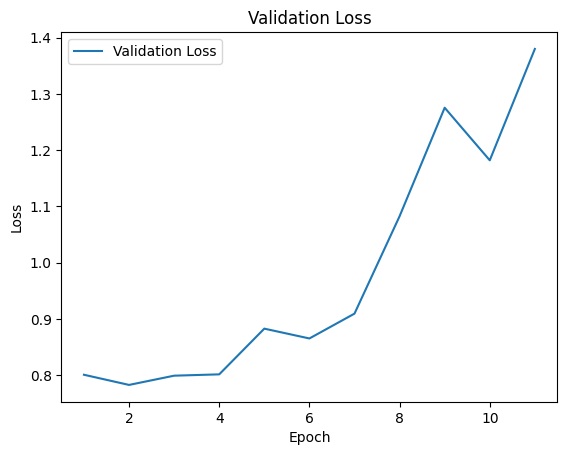

In [ ]:
plt.figure()  # Initializeaza o noua figura pentru a desena graficul
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')  # Traseaza graficul pierderilor de antrenament
plt.xlabel('Epoch')  # Eticheteaza axa x cu 'Epoch'
plt.ylabel('Loss')  # Eticheteaza axa y cu 'Loss'
plt.title('Training Loss')  # Seteaza titlul graficului ca 'Training Loss'
plt.legend()  # Adauga legenda graficului
plt.show()  # Afiseaza graficul

plt.figure()  # Initializeaza o noua figura pentru al doilea grafic
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')  # Traseaza graficul pierderilor de validare
plt.xlabel('Epoch')  # Eticheteaza axa x cu 'Epoch'
plt.ylabel('Loss')  # Eticheteaza axa y cu 'Loss'
plt.title('Validation Loss')  # Seteaza titlul graficului ca 'Validation Loss'
plt.legend()  # Adauga legenda graficului
plt.show()  # Afiseaza graficul

## 3.2.2. Experimente cu learning rate-ul

Bulina 5:

## Observatii generale
Ca la Observatii generale de la 3.2 doar ca la Observatii: modelul se antreneaza bine, este simplu structurat si are performante bune.

Scheduler(optimieaza-update la parametrii dupa fiecare epoca) il am prezent in Bulina 7.

In [ ]:
ensemble_models.append(model)  # Adauga modelul curent in lista de modele ensemble

model = SimpleCNN(num_classes=len(dataset.classes))  # Creeaza un nou model CNN pentru clasificarea imaginilor

criterion = nn.CrossEntropyLoss()  # Defineste criteriul de pierdere ca fiind pierderea de entropie incrucisata
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Seteaza optimizatorul cu un learning rate de 10% - LEARNING RATE

train_size = int(0.8 * len(dataset))  # Calculeaza dimensiunea setului de antrenament ca 80% din dataset
val_size = len(dataset) - train_size  # Restul datelor va fi pentru validare

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  # Imparte dataset-ul in seturi de antrenament si validare

batch_size = 32  # Stabileste dimensiunea unui batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Loader pentru antrenament cu shuffle activat
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # Loader pentru validare

num_epochs = 50  # Numarul de epoci pentru care se va rula antrenamentul

train_losses = []  # Lista pentru stocarea pierderilor la antrenament
val_losses = []  # Lista pentru stocarea pierderilor la validare

best_val_accuracy = 0.0  # Cea mai buna acuratete la validare initializata cu 0
patience = 10  # Numarul de epoci de asteptat pentru imbunatatire inainte de a opri antrenamentul
no_improvement_count = 0  # Contor pentru epocile fara imbunatatire

for epoch in range(num_epochs):  # Loop prin fiecare epoca
    model.train()  # Seteaza modelul in modul de antrenament
    train_loss = 0.0  # Initializeaza pierderea de antrenament pentru epoca curenta
    try:
      for images, labels in train_loader:  # Itereaza prin fiecare batch din loader-ul de antrenament
          optimizer.zero_grad()  # Reseteaza gradientii optimizatorului
          outputs = model(images)  # Obtine predictiile modelului pentru imaginile actuale
          loss = criterion(outputs, labels)  # Calculeaza pierderea
          loss.backward()  # Calculeaza gradientii
          optimizer.step()  # Actualizeaza parametrii modelului
          train_loss += loss.item() * images.size(0)  # Adauga pierderea scalata la pierderea totala de antrenament
    except:
      print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
    train_loss /= len(train_loader.dataset)  # Calculeaza pierderea medie de antrenament

    model.eval()  # Seteaza modelul in modul de evaluare
    val_loss = 0.0  # Initializeaza pierderea de validare pentru epoca curenta
    with torch.no_grad():  # Dezactiveaza calculul gradientilor pentru evaluare
        total_correct = 0  # Numarul total de predictii corecte
        total_samples = 0  # Numarul total de probe
        for images, labels in val_loader:  # Itereaza prin fiecare batch din loader-ul de validare
            outputs = model(images)  # Obtine predictiile modelului pentru imaginile actuale
            loss = criterion(outputs, labels)  # Calculeaza pierderea
            val_loss += loss.item() * images.size(0)  # Adauga pierderea scalata la pierderea totala de validare
            _, predicted = torch.max(outputs, 1)  # Determina clasificarile cu cea mai mare probabilitate
            total_samples += labels.size(0)  # Adauga numarul de etichete la totalul de probe
            total_correct += (predicted == labels).sum().item()  # Contorizeaza predictiile corecte
        val_loss /= len(val_loader.dataset)  # Calculeaza pierderea medie de validare

    train_losses.append(train_loss)  # Adauga pierderea de antrenament la lista de pierderi
    val_losses.append(val_loss)  # Adauga pierderea de validare la lista de pierderi

    accuracy = total_correct / total_samples  # Calculeaza acuratetea
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')  # Afiseaza rezultatele pentru epoca

    if accuracy > best_val_accuracy:  # Verifica daca acuratetea curenta este cea mai buna
        best_val_accuracy = accuracy  # Actualizeaza cea mai buna acuratete
        no_improvement_count = 0  # Resetaza contorul de epoci fara imbunatatire
    else:
        no_improvement_count += 1  # Incrementeaza contorul de epoci fara imbunatatire

    if no_improvement_count >= patience:  # Verifica daca s-a atins limita de rabdare
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')  # Anunta oprirea antrenamentului
        break  # Iesire din bucla de epoci


<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


Epoch [1/50], Train Loss: 257857.9675, Validation Loss: 0.9045, Validation Accuracy: 0.66
Epoch [2/50], Train Loss: 0.8195, Validation Loss: 0.8696, Validation Accuracy: 0.66
Epoch [3/50], Train Loss: 0.8165, Validation Loss: 0.8793, Validation Accuracy: 0.66
Epoch [4/50], Train Loss: 0.8190, Validation Loss: 0.8745, Validation Accuracy: 0.66
Epoch [5/50], Train Loss: 0.8319, Validation Loss: 0.9052, Validation Accuracy: 0.66
Epoch [6/50], Train Loss: 0.8158, Validation Loss: 0.8636, Validation Accuracy: 0.66
Epoch [7/50], Train Loss: 0.8180, Validation Loss: 0.8707, Validation Accuracy: 0.66
Epoch [8/50], Train Loss: 0.8213, Validation Loss: 0.8723, Validation Accuracy: 0.66
Epoch [9/50], Train Loss: 0.8255, Validation Loss: 0.8703, Validation Accuracy: 0.66
Epoch [10/50], Train Loss: 0.8184, Validation Loss: 0.8691, Validation Accuracy: 0.66
Epoch [11/50], Train Loss: 0.8280, Validation Loss: 0.8819, Validation Accuracy: 0.66
No improvement in validation accuracy for 10 epochs. Stopp

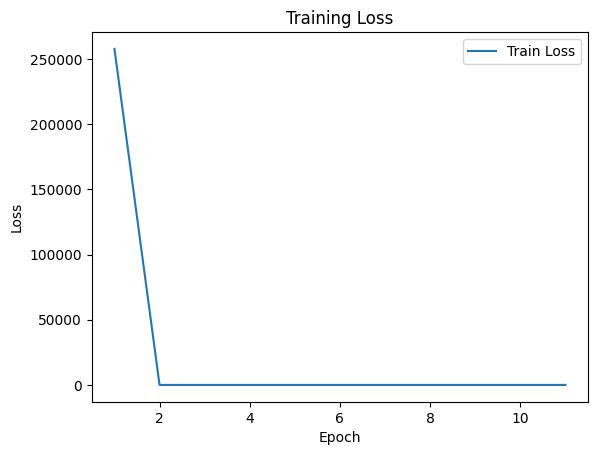

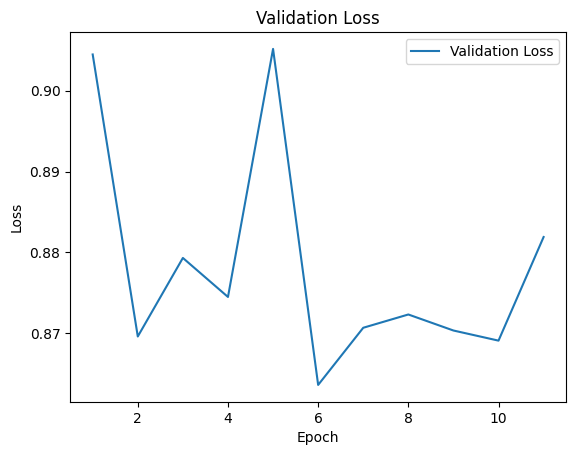

In [ ]:
plt.figure()  # Initializeaza o noua figura pentru a desena graficul
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')  # Traseaza graficul pierderilor de antrenament
plt.xlabel('Epoch')  # Eticheteaza axa x cu 'Epoch'
plt.ylabel('Loss')  # Eticheteaza axa y cu 'Loss'
plt.title('Training Loss')  # Seteaza titlul graficului ca 'Training Loss'
plt.legend()  # Adauga legenda graficului
plt.show()  # Afiseaza graficul

plt.figure()  # Initializeaza o noua figura pentru al doilea grafic
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')  # Traseaza graficul pierderilor de validare
plt.xlabel('Epoch')  # Eticheteaza axa x cu 'Epoch'
plt.ylabel('Loss')  # Eticheteaza axa y cu 'Loss'
plt.title('Validation Loss')  # Seteaza titlul graficului ca 'Validation Loss'
plt.legend()  # Adauga legenda graficului
plt.show()  # Afiseaza graficul

## 3.2.3 Experimente cu optimizatorii

Bulina 6:

## Observatii generale
Ca la Observatii generale de la 3.2 doar ca la Optimizator avem SGD in loc de Adam.

 Atât SGD, cât și Adam sunt algoritmi de optimizare foarte populari în contextul clasificării. Diferența principală între cei doi constă în faptul că SGD utilizează un learning rate constant, în timp ce Adam are un learning rate variabil. Deși modelul optimizat cu SGD are o performanță bună, în acest caz particular, s-a observat că performanța este inferioară comparativ cu modelul optimizat cu Adam. Cu toate acestea, pentru clasificarea de imagini, se pare că SGD ar fi mai potrivit datorită stabilității oferite de learning rate-ul constant, care poate facilita convergența către soluția optimă în anumite scenarii.

 Adam am la Bulina 5.

In [ ]:
ensemble_models.append(model)  # Adauga modelul curent la lista de modele ansamblu.

model = SimpleCNN(num_classes=len(dataset.classes))  # Creeaza un nou model CNN cu un numar de clase egal cu numarul de clase din dataset.

criterion = nn.CrossEntropyLoss()  # Defineste criteriul de pierdere ca fiind pierderea entropiei incrucisate.
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  # Defineste optimizatorul ca fiind SGD (descent gradient stochastic) cu rata de invatare 0.001.

train_size = int(0.8 * len(dataset))  # Calculeaza dimensiunea setului de antrenament ca fiind 80% din dataset.
val_size = len(dataset) - train_size  # Calculeaza dimensiunea setului de validare ca fiind restul de 20%.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])  # Imparte datasetul in set de antrenament si validare.

batch_size = 32  # Defineste dimensiunea lotului pentru incarcare.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creeaza incarcatorul de date pentru antrenament cu amestecare.
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # Creeaza incarcatorul de date pentru validare.

num_epochs = 50  # Defineste numarul de epoci pentru antrenament.

train_losses = []  # Initializeaza lista pentru a stoca pierderile de antrenament.
val_losses = []  # Initializeaza lista pentru a stoca pierderile de validare.

best_val_accuracy = 0.0  # Initializeaza cea mai buna acuratete de validare.
patience = 10  # Seteaza numarul de epoci de asteptare fara imbunatatiri pentru a opri antrenamentul.
no_improvement_count = 0  # Initializeaza contorul pentru epoci fara imbunatatire.

for epoch in range(num_epochs):  # Incepe bucla pentru fiecare epoca.
    model.train()  # Seteaza modelul pe modul de antrenament.
    train_loss = 0.0  # Initializeaza pierderea de antrenament pentru epoca curenta.
    try:
      for images, labels in train_loader:  # Parcurge loturile din setul de antrenament.
          optimizer.zero_grad()  # Reseteaza gradientii optimizatorului.
          outputs = model(images)  # Calculeaza iesirile modelului pentru imaginile actuale.
          loss = criterion(outputs, labels)  # Calculeaza pierderea pentru iesirile modelului comparativ cu etichetele reale.
          loss.backward()  # Calculeaza gradientii.
          optimizer.step()  # Actualizeaza parametrii modelului folosind gradientii calculati.
          train_loss += loss.item() * images.size(0)  # Aduna pierderea ponderata cu numarul de imagini la pierderea totala de antrenament.
    except:
      print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
    train_loss /= len(train_loader.dataset)  # Calculeaza pierderea medie de antrenament.

    model.eval()  # Seteaza modelul pe modul de evaluare (fara antrenament).
    val_loss = 0.0  # Initializeaza pierderea de validare pentru epoca curenta.
    with torch.no_grad():  # Blocheaza calculul gradientilor pentru optimizarea memoriei.
        total_correct = 0  # Initializeaza numarul total de predictii corecte.
        total_samples = 0  # Initializeaza numarul total de probe evaluate.
        try:
          for images, labels in val_loader:  # Parcurge loturile din setul de validare.
              outputs = model(images)  # Calculeaza iesirile modelului pentru imaginile de validare.
              loss = criterion(outputs, labels)  # Calculeaza pierderea pentru iesirile modelului comparativ cu etichetele reale.
              val_loss += loss.item() * images.size(0)  # Aduna pierderea ponderata cu numarul de imagini la pierderea totala de validare.
              _, predicted = torch.max(outputs, 1)  # Determina etichetele prezise pe baza iesirilor modelului.
              total_samples += labels.size(0)  # Actualizeaza numarul total de probe evaluate.
              total_correct += (predicted == labels).sum().item()  # Actualizeaza numarul de predictii corecte.
        except:
          print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
        val_loss /= len(val_loader.dataset)  # Calculeaza pierderea medie de validare.

    train_losses.append(train_loss)  # Adauga pierderea de antrenament la lista de pierderi.
    val_losses.append(val_loss)  # Adauga pierderea de validare la lista de pierderi.

    accuracy = total_correct / total_samples  # Calculeaza acuratetea de validare.
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}')  # Tipareste rezultatele pentru epoca curenta.

    if accuracy > best_val_accuracy:  # Verifica daca acuratetea curenta este mai buna decat cea mai buna pana acum.
        best_val_accuracy = accuracy  # Actualizeaza cea mai buna acuratete.
        no_improvement_count = 0  # Reseteaza contorul de epoci fara imbunatatire.
    else:
        no_improvement_count += 1  # Incrementa contorul de epoci fara imbunatatire.

    if no_improvement_count >= patience:  # Verifica daca numarul de epoci fara imbunatatire a atins pragul de rabdare.
        print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.')  # Tipareste un mesaj de oprire a antrenamentului daca nu exista imbunatatiri.
        break  # Intrerupe bucla de antrenament.


<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


Epoch [1/50], Train Loss: 0.9388, Validation Loss: 0.8604, Validation Accuracy: 0.66
Epoch [2/50], Train Loss: 0.8402, Validation Loss: 0.8390, Validation Accuracy: 0.66
Epoch [3/50], Train Loss: 0.8337, Validation Loss: 0.8340, Validation Accuracy: 0.66
Epoch [4/50], Train Loss: 0.8304, Validation Loss: 0.8321, Validation Accuracy: 0.66
Epoch [5/50], Train Loss: 0.8296, Validation Loss: 0.8297, Validation Accuracy: 0.66
Epoch [6/50], Train Loss: 0.8271, Validation Loss: 0.8290, Validation Accuracy: 0.66
Epoch [7/50], Train Loss: 0.8249, Validation Loss: 0.8325, Validation Accuracy: 0.66
Epoch [8/50], Train Loss: 0.8251, Validation Loss: 0.8299, Validation Accuracy: 0.66
Epoch [9/50], Train Loss: 0.8239, Validation Loss: 0.8286, Validation Accuracy: 0.66
Epoch [10/50], Train Loss: 0.8227, Validation Loss: 0.8293, Validation Accuracy: 0.66
Epoch [11/50], Train Loss: 0.8208, Validation Loss: 0.8299, Validation Accuracy: 0.66
No improvement in validation accuracy for 10 epochs. Stopping t

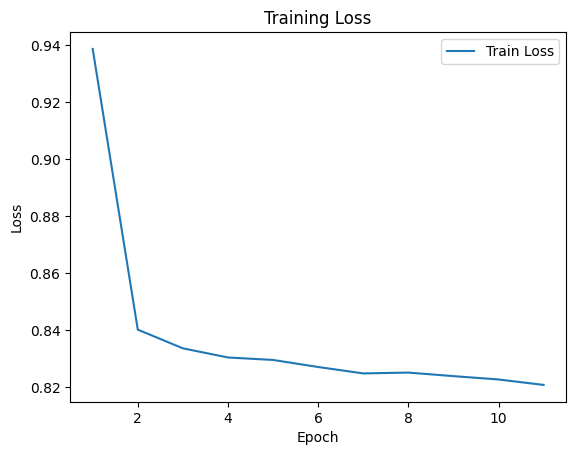

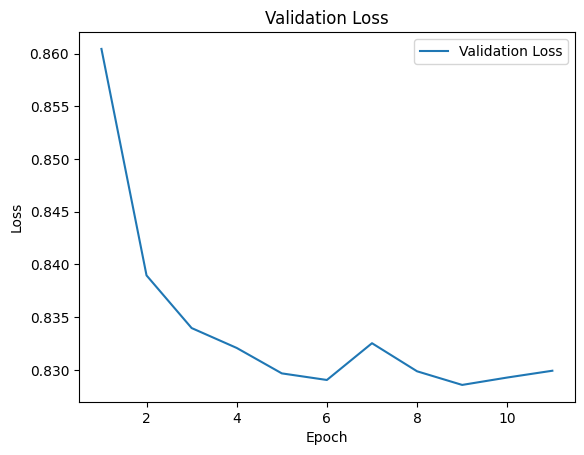

In [ ]:
plt.figure()  # Initializeaza o noua figura pentru a desena graficul
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')  # Traseaza graficul pierderilor de antrenament
plt.xlabel('Epoch')  # Eticheteaza axa x cu 'Epoch'
plt.ylabel('Loss')  # Eticheteaza axa y cu 'Loss'
plt.title('Training Loss')  # Seteaza titlul graficului ca 'Training Loss'
plt.legend()  # Adauga legenda graficului
plt.show()  # Afiseaza graficul

plt.figure()  # Initializeaza o noua figura pentru al doilea grafic
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')  # Traseaza graficul pierderilor de validare
plt.xlabel('Epoch')  # Eticheteaza axa x cu 'Epoch'
plt.ylabel('Loss')  # Eticheteaza axa y cu 'Loss'
plt.title('Validation Loss')  # Seteaza titlul graficului ca 'Validation Loss'
plt.legend()  # Adauga legenda graficului
plt.show()  # Afiseaza graficul

## 3.2.4 Function losses

Bulina 7:



## Observatii generale
Ca la Observatii generale de la 3.2 doar ca la Observatii: modelul se antreneaza bine, este simplu structurat si are performante bune.

Am facut o ponderata/combinatie pe functiile de loss folosite.

Am folosit scheduler aici in loc de Bulina 5.

Sigur, iată explicațiile pentru fiecare criteriu de pierdere în 5 rânduri:

### CrossEntropyLoss
CrossEntropyLoss este utilizată pentru sarcinile de clasificare, calculând pierderea între probabilitățile prezise ale claselor și etichetele reale. Combină nn.LogSoftmax() și nn.NLLLoss(), facilitând procesul de antrenare. Se așteaptă ca etichetele țintă să fie indici de clasă. Este ideală pentru clasificare multi-clasă și necesită ca stratul de ieșire să aibă o activare softmax.

Observatii: Cam aceas problema ca la Relu, exponentialul de la un punct se plafoneaza si nu ofera o distributie foarte buna pentru clasificatorul modelat de mine. In practica este foarte util, dar nu se modeleaza bine pe structura creata de mine.

### KLDivLoss
KLDivLoss măsoară divergența Kullback-Leibler între două distribuții probabilistice, evaluând cât de mult diferă o distribuție de la alta. Este folosită frecvent în modele probabilistice, precum Variational Autoencoders (VAEs) sau distilarea modelului profesor-elev. Parametrul reduction='batchmean` asigură media pierderii pe lot. Intrarea trebuie să fie log-probabilități, iar ținta probabilități.

### MSELoss
MSELoss calculează eroarea pătratică medie între valorile prezise și cele reale, fiind folosită în sarcinile de regresie. Este ideală pentru probleme unde ieșirea este o variabilă continuă. Aceasta ajută la minimizarea diferențelor pătratice dintre predicții și ținte. Atât intrarea, cât și ținta trebuie să aibă aceeași formă.



<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta



Epoch 1/50 - Train loss: 3.2134, Valid loss: 1.4170
 

Epoch 2/50 - Train loss: 1.4308, Valid loss: 1.3915
 

Epoch 3/50 - Train loss: 1.3887, Valid loss: 1.3797
 

Epoch 4/50 - Train loss: 1.3826, Valid loss: 1.3779
 

Epoch 5/50 - Train loss: 1.3777, Valid loss: 1.3774
 

Epoch 6/50 - Train loss: 1.3775, Valid loss: 1.3771
 

Epoch 7/50 - Train loss: 1.3771, Valid loss: 1.3771
 

Epoch 8/50 - Train loss: 1.3771, Valid loss: 1.3770
 

Epoch 9/50 - Train loss: 1.3770, Valid loss: 1.3770
 

Epoch 10/50 - Train loss: 1.3770, Valid loss: 1.3770
 

Epoch 11/50 - Train loss: 1.3770, Valid loss: 1.3770
 

Epoch 12/50 - Train loss: 1.3770, Valid loss: 1.3770
 

Epoch 13/50 - Train loss: 1.3770, Valid loss: 1.3770
 

Epoch 14/50 - Train loss: 1.3770, Valid loss: 1.3770
 

Epoch 15/50 - Train loss: 1.3770, Valid loss: 1.3770
 

Epoch 16/50 - Train loss: 1.3770, Valid loss: 1.3770
 

Epoch 17/50 - Train loss: 1.3770, Valid loss: 1.3770
 

Epoch 18/50 - Train loss: 1.3770, Valid loss: 1.3770
 



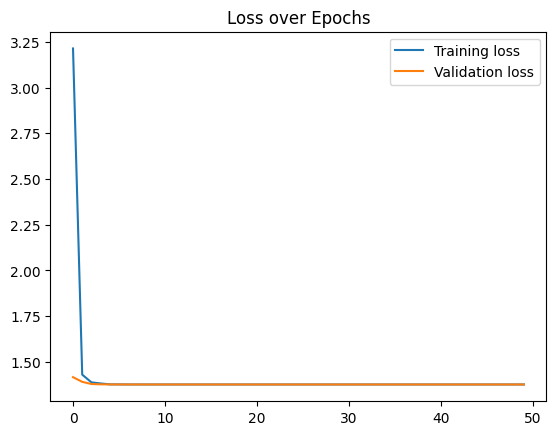

In [ ]:
# Definirea unei functii pentru netezirea etichetelor
def label_smoothing(labels, classes, smoothing=0.1):
    confidence = 1.0 - smoothing  # Nivelul de incredere in eticheta corecta
    label_shape = torch.Size((labels.size(0), classes))  # Forma tensorului pentru distributia etichetelor
    with torch.no_grad():  # Bloc pentru a opri urmarirea gradientului
        true_dist = torch.empty(size=label_shape, device=labels.device)  # Crearea unui tensor gol
        true_dist.fill_(smoothing / (classes - 1))  # Umplerea tensorului cu valoarea netezita
        true_dist.scatter_(1, labels.data.unsqueeze(1), confidence)  # Actualizarea tensorului cu increderea corecta
    return true_dist  # Returnarea tensorului netezit

# Configurarea modelului
num_classes = 3  # Numarul de clase
num_epochs = 50  # Numarul de epoci
train_losses, valid_losses = [], []  # Liste pentru stocarea pierderilor

model = SimpleCNN(num_classes=num_classes)  # Initializarea modelului
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Selectarea dispozitivului de calcul
model.to(device)  # Trimiterea modelului pe dispozitiv

criterion = nn.CrossEntropyLoss()  # Initializarea criteriului de pierdere CrossEntropy
kl_criterion = nn.KLDivLoss(reduction='batchmean')  # Initializarea criteriului de pierdere Kullback-Leibler
mse_criterion = nn.MSELoss()  # Initializarea criteriului de pierdere Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Initializarea optimizatorului
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)  # Initializarea programatorului de rata de invatare

# Bucla de antrenare si validare
for epoch in range(num_epochs):
    model.train()  # Setarea modelului in modul de antrenare
    running_loss = 0.0  # Initializarea pierderii cumulative
    for images, labels in train_loader:  # Iterarea prin loturile de antrenare
        images, labels = images.to(device), labels.to(device)  # Trimiterea datelor pe dispozitiv
        optimizer.zero_grad()  # Resetarea gradientilor

        outputs = model(images)  # Calcularea iesirilor modelului
        ce_loss = criterion(outputs, labels)  # Calcularea pierderii CrossEntropy
        soft_labels = label_smoothing(labels, num_classes)  # Aplicarea netezirii etichetelor
        kl_loss = kl_criterion(F.log_softmax(outputs, dim=1), soft_labels)  # Calcularea pierderii KL
        mse_loss = mse_criterion(outputs, soft_labels)  # Calcularea pierderii MSE
        combined_loss = ce_loss + kl_loss + 0.1 * mse_loss  # Combinarea pierderilor

        combined_loss.backward()  # Backpropagation
        optimizer.step()  # Actualizarea parametrilor modelului
        running_loss += combined_loss.item() * images.size(0)  # Actualizarea pierderii cumulative
    train_loss = running_loss / len(train_loader.dataset)  # Calcularea pierderii medii de antrenare
    train_losses.append(train_loss)  # Salvarea pierderii de antrenare

    model.eval()  # Setarea modelului in modul de evaluare
    running_loss = 0.0  # Resetarea pierderii cumulative
    with torch.no_grad():  # Bloc pentru a opri urmarirea gradientului
        for images, labels in val_loader:  # Iterarea prin loturile de validare
            images, labels = images.to(device), labels.to(device)  # Trimiterea datelor pe dispozitiv
            outputs = model(images)  # Calcularea iesirilor modelului
            ce_loss = criterion(outputs, labels)  # Calcularea pierderii CrossEntropy
            soft_labels = label_smoothing(labels, num_classes)  # Aplicarea netezirii etichetelor
            kl_loss = kl_criterion(F.log_softmax(outputs, dim=1), soft_labels)  # Calcularea pierderii KL
            mse_loss = mse_criterion(outputs, soft_labels)  # Calcularea pierderii MSE
            combined_loss = ce_loss + kl_loss + 0.1 * mse_loss  # Combinarea pierderilor
            running_loss += combined_loss.item() * images.size(0)  # Actualizarea pierderii cumulative
        valid_loss = running_loss / len(val_loader.dataset)  # Calcularea pierderii medii de validare
        valid_losses.append(valid_loss)  # Salvarea pierderii de validare

    # Afisarea statisticilor pe epoca
    print(f"\nEpoch {epoch + 1}/{num_epochs} - Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}\n ")

    scheduler.step()  # Actualizarea ratei de invatare

# Crearea graficului cu pierderile
plt.plot(train_losses, label='Training loss')  # Plottarea pierderilor de antrenare
plt.plot(valid_losses, label='Validation loss')  # Plottarea pierderilor de validare
plt.legend()  # Adaugarea legendei
plt.title('Loss over Epochs')  # Adaugarea titlului
plt.show()  # Afisarea graficului


## 3.2.5 OPT, Accuracy Recall, Confusion Matrix

Bulina 8:

## Observatii generale

E destinat să ofere predicții mai robuste și să evalueze incertitudinea acestora prin entropie. În primul pas, un model antrenat este adăugat la o listă de modele de ansamblu. Următorul pas implică inițializarea indicilor pentru seturile de antrenament și validare și crearea de sampler-e care extrag aleatoriu exemple din aceste seturi, utilizate apoi pentru a alimenta încărcătoarele de date.

Funcția de entropie este definită pentru a calcula incertitudinea predicțiilor, folosind funcția softmax pentru a estima probabilitățile, după care se aplică logaritmii acestora pentru a obține entropia. În procesul de predicție, pentru fiecare lot de imagini din setul de validare, fiecare model din ansamblu contribuie la predicția finală, iar rezultatul este mediat pentru a forma predicția de ansamblu.

Dacă apar erori în timpul predicției, sunt afișate mesaje de eroare și se sugerează pași pentru remedierea situației. Când se obțin predicțiile de ansamblu, se calculează entropia acestora ca măsură a incertitudinii. De asemenea, se evaluează performanța modelului prin calculul acurateței și recall-ului și se generează o matrice de confuzie pentru a vizualiza performanța clasificărilor.

În final, rezultatele și analizele sunt integrate în TensorBoard prin intermediul unui SummaryWriter din TensorBoard, permițând vizualizarea și analiza mai detaliată a performanței modelului de ansamblu. Această implementare ilustrează cum ansamblurile de modele pot îmbunătăți fiabilitatea predicțiilor și oferi evaluări ale incertitudinii în aplicații de învățare automată.

In [ ]:
# Adaugam modelul la lista de modele de ansamblu
ensemble_models.append(model)

# Dupa antrenarea modelului
# Calculam entropia pentru a evalua cat de incert este modelul
train_idx = list(range(len(train_dataset)))  # Lista cu indici pentru toate exemplele din setul de antrenament
val_idx = list(range(len(val_dataset)))      # Lista cu indici pentru toate exemplele din setul de validare

train_sampler = SubsetRandomSampler(train_idx)  # Creaza un sampler care selecteaza elemente random din setul de antrenament
val_sampler = SubsetRandomSampler(val_idx)      # Creaza un sampler care selecteaza elemente random din setul de validare

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)  # Incarcatorul de date pentru antrenament
val_loader = DataLoader(val_dataset, batch_size=32, sampler=val_sampler)        # Incarcatorul de date pentru validare

# Defineste functia de entropie
def entropy(predictions):
    probs = F.softmax(predictions, dim=1)          # Calculeaza probabilitatile pentru fiecare clasa folosind softmax
    log_probs = torch.log2(probs)                  # Calculeaza logaritmul in baza 2 al probabilitatilor
    entropy_per_instance = -torch.sum(probs * log_probs, dim=1)  # Calculeaza entropia pentru fiecare instanta
    return torch.mean(entropy_per_instance).item() # Returneaza media entropiei pe toate instantele

# Predictii de ansamblu
ensemble_predictions = []
try:
    for images, labels in val_loader:  # Itereaza prin setul de validare
        with torch.no_grad():  # Blocheaza calculul de gradienti pentru optimizarea memoriei
            ensemble_output = torch.zeros(images.size(0), len(train_dataset.classes))  # Initializare tensor pentru outputul ansamblului
            for model in ensemble_models:  # Itereaza prin fiecare model din ansamblu
                model.eval()  # Pune modelul in modul de evaluare
                outputs = model(images)  # Obtine predictiile modelului pentru imaginile date
                ensemble_output += outputs  # Aduna predictiile la outputul total al ansamblului
            ensemble_output /= len(ensemble_models)  # Calculeaza media predictiilor
            ensemble_predictions.append(ensemble_output)  # Adauga predictiile medii la lista de predictii de ansamblu
except Exception as e:
    print(f"An error occurred: {e}")  # Afiseaza eroarea
    print("Please re-run the loaders and model or process fewer images.")  # Sfaturi pentru depanare
    train_subset = Subset(train_dataset, train_idx)  # Creaza un subset de antrenament (necesar pentru reluare)
    val_subset = Subset(val_dataset, val_idx)        # Creaza un subset de validare (necesar pentru reluare)

if ensemble_predictions:
    ensemble_predictions = torch.cat(ensemble_predictions, dim=0)  # Concateneaza toate predictiile de ansamblu
    ensemble_entropy = entropy(ensemble_predictions)  # Calculeaza entropia pentru predictiile de ansamblu

    # Calculeaza acuratetea si recall-ul
    ensemble_predicted_labels = torch.argmax(ensemble_predictions, dim=1)  # Determina clasa prezisa pentru fiecare instanta
    ensemble_accuracy = accuracy_score(val_dataset.targets, ensemble_predicted_labels)  # Calculeaza acuratetea
    ensemble_recall = recall_score(val_dataset.targets, ensemble_predicted_labels, average='macro')  # Calculeaza recall-ul

    # Genereaza matricea de confuzie
    conf_matrix = confusion_matrix(val_dataset.targets, ensemble_predicted_labels)

    writer = SummaryWriter()  # Initializeaza un writer pentru TensorBoard

    # Creeaza heatmap pentru matricea de confuzie
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(conf_matrix, cmap='viridis')  # Afiseaza matricea sub forma de heatmap

    # Adauga etichetele
    ax.set_xticks(np.arange(len(train_dataset.classes)))
    ax.set_yticks(np.arange(len(train_dataset.classes)))
    ax.set_xticklabels(train_dataset.classes, rotation=45)
    ax.set_yticklabels(train_dataset.classes)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix')

    # Creeaza adnotarile textuale pentru matrice
    for i in range(len(train_dataset.classes)):
        for j in range(len(train_dataset.classes)):
            text = ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='w')

    # Adauga figura in TensorBoard
    writer.add_figure('Confusion Matrix', fig)
else:
    print("Ensemble predictions list is empty. Cannot compute entropy.")  # Mesaj de eroare daca lista de predictii este goala


<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


An error occurred: 'Subset' object has no attribute 'classes'
Please re-run the loaders and model or process fewer images.
Ensemble predictions list is empty. Cannot compute entropy.


## 3.2.6  Cross validation

Bulina 9:

## Observatii generale

 Începe cu inițializarea variabilelor cheie pentru acuratețe, paciență și numărul de epoci. Folosind KFold, împarte setul de date în subseturi pentru antrenament și validare. Un model, criteriul de pierdere și un optimizer sunt configurate pentru fiecare fold. În fiecare epocă, datele sunt procesate în batch-uri pentru antrenament, iar apoi modelul este evaluat pe setul de validare. Acuratețea este calculată și comparată cu cea mai bună acuratețe anterioară, iar antrenamentul poate fi oprit dacă nu există îmbunătățiri după un număr definit de epoci. La sfârșit, sunt afișate rezultatele pentru fiecare fold.

In [ ]:
best_val_accuracy = 0.0 # Initializeaza cea mai buna acuratete de validare cu 0.0
patience = 10 # Seteaza numarul de epoci fara imbunatatire inainte de a opri antrenamentul
no_improvement_count = 0 # Contor pentru numarul de epoci fara imbunatatiri
num_epochs = 50 # Numarul total de epoci pentru antrenare
k_folds = 3 # Numarul de subseturi pentru validarea incrucișată
kf = KFold(n_splits=k_folds) # Crearea unui obiect KFold pentru a imparti datele in k subseturi

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)): # Parcurge fiecare pliere, obtinand indexii pentru antrenare si validare
    print(f'Fold {fold + 1}/{k_folds}') # Afiseaza numarul curent al plierii

    train_subset = torch.utils.data.Subset(dataset, train_idx) # Creeaza un subset de antrenament folosind indexii
    val_subset = torch.utils.data.Subset(dataset, val_idx) # Creeaza un subset de validare folosind indexii

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True) # Initializeaza DataLoader pentru antrenament
    val_loader = DataLoader(val_subset, batch_size=batch_size) # Initializeaza DataLoader pentru validare

    model = SimpleCNN(num_classes=len(dataset.classes)) # Initializeaza modelul cu numarul de clase din dataset

    criterion = nn.CrossEntropyLoss() # Defineste criteriul de pierdere ca fiind pierderea entropiei incrucisate
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Defineste optimizerul, folosind Adam

    best_val_accuracy = 0.0 # Reseteaza cea mai buna acuratete de validare pentru plierea curenta
    no_improvement_count = 0 # Reseteaza contorul de epoci fara imbunatatiri

    for epoch in range(num_epochs): # Incepe bucla pentru epoci
        model.train() # Seteaza modelul pe modul de antrenament
        train_loss = 0.0 # Initializeaza pierderea de antrenament cu 0.0
        try:
            for images, labels in train_loader: # Parcurge fiecare batch din loader-ul de antrenament
                optimizer.zero_grad() # Reseteaza gradientii in optimizer
                outputs = model(images) # Calculeaza iesirile modelului
                loss = criterion(outputs, labels) # Calculeaza pierderea
                loss.backward() # Calculeaza gradientii
                optimizer.step() # Actualizeaza parametrii modelului
                train_loss += loss.item() * images.size(0) # Adauga pierderea ponderata la pierderea totala de antrenament
        except:
          print("Imaginea nu a putut fi deschisa. Ai doua optiuni: dai re-run la loadere sau lasi asa si proceseaza mai putine imagini.")
        train_loss /= len(train_loader.dataset) # Calculeaza pierderea medie de antrenament

        model.eval() # Seteaza modelul pe modul de evaluare
        val_loss = 0.0 # Initializeaza pierderea de validare cu 0.0
        with torch.no_grad(): # Dezactiveaza calculul gradientilor pentru evaluare
            total_correct = 0 # Numara totalul de predictii corecte
            total_samples = 0 # Numara totalul de probe evaluate
            for images, labels in val_loader: # Parcurge fiecare batch din loader-ul de validare
                outputs = model(images) # Calculeaza iesirile modelului pentru validare
                loss = criterion(outputs, labels) # Calculeaza pierderea pentru validare
                val_loss += loss.item() * images.size(0) # Adauga pierderea ponderata la pierderea totala de validare
                _, predicted = torch.max(outputs, 1) # Determina predictiile ca fiind clasele cu probabilitatea maxima
                total_samples += labels.size(0) # Actualizeaza numarul total de probe evaluate
                total_correct += (predicted == labels).sum().item() # Actualizeaza numarul total de predictii corecte
            val_loss /= len(val_loader.dataset) # Calculeaza pierderea medie de validare

        accuracy = total_correct / total_samples # Calculeaza acuratetea de validare

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}') # Afiseaza rezultatele pentru epoca

        if accuracy > best_val_accuracy: # Verifica daca acuratetea curenta este mai buna decat cea mai buna pana acum
            best_val_accuracy = accuracy # Actualizeaza cea mai buna acuratete
            no_improvement_count = 0 # Reseteaza contorul de epoci fara imbunatatiri
        else:
            no_improvement_count += 1 # Incrementeaza contorul de epoci fara imbunatatiri

        if no_improvement_count >= patience: # Verifica daca s-a atins numarul de epoci fara imbunatatiri
            print(f'No improvement in validation accuracy for {patience} epochs. Stopping training.') # Afiseaza mesajul de oprire a antrenamentului
            break # Intrerupe bucla de epoci

    print(f'Best Validation Accuracy for Fold {fold + 1}: {best_val_accuracy:.4f}') # Afiseaza cea mai buna acuratete de validare pentru plierea curenta


Fold 1/3


<ipython-input-74-604ff201dd2c>:26: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(self.target_size, Image.ANTIALIAS)  # Redimensioneaza imaginea la dimensiunea tinta


Epoch [1/50], Train Loss: 1.8681, Validation Loss: 0.7194, Validation Accuracy: 1.00
Epoch [2/50], Train Loss: 0.9936, Validation Loss: 0.5596, Validation Accuracy: 1.00
Epoch [3/50], Train Loss: 0.9832, Validation Loss: 0.6192, Validation Accuracy: 1.00
Epoch [4/50], Train Loss: 0.9597, Validation Loss: 0.6672, Validation Accuracy: 0.89
Epoch [5/50], Train Loss: 0.9696, Validation Loss: 0.5955, Validation Accuracy: 0.99
Epoch [6/50], Train Loss: 0.9379, Validation Loss: 0.7204, Validation Accuracy: 0.72
Epoch [7/50], Train Loss: 0.9128, Validation Loss: 0.7163, Validation Accuracy: 0.82
Epoch [8/50], Train Loss: 0.8860, Validation Loss: 0.8162, Validation Accuracy: 0.55
Epoch [9/50], Train Loss: 0.8593, Validation Loss: 0.8078, Validation Accuracy: 0.59
Epoch [10/50], Train Loss: 0.8593, Validation Loss: 0.5016, Validation Accuracy: 0.84
Epoch [11/50], Train Loss: 0.7767, Validation Loss: 0.8837, Validation Accuracy: 0.52
No improvement in validation accuracy for 10 epochs. Stopping t